In [83]:
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import model_selection

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

%matplotlib inline

In [84]:
start = datetime(2000,2,1)
end = datetime.now()

In [85]:
AMT = web.DataReader('AMT', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
AMT = AMT.copy()
AMT.index = pd.to_datetime(AMT.index)
AMT = AMT.resample('MS').mean()
AMT['name'] = pd.Series()
AMT['name'] = 'AMT'

ELS = web.DataReader('ELS', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
ELS = ELS.copy()
ELS.index = pd.to_datetime(ELS.index)
ELS = ELS.resample('MS').mean()
ELS['name'] = pd.Series()
ELS['name'] = 'ELS'

PLD = web.DataReader('PLD', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
PLD = PLD.copy()
PLD.index = pd.to_datetime(PLD.index)
PLD = PLD.resample('MS').mean()
PLD['name'] = pd.Series()
PLD['name'] = 'PLD'

FR = web.DataReader('FR', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
FR = FR.copy()
FR.index = pd.to_datetime(FR.index)
FR = FR.resample('MS').mean()
FR['name'] = pd.Series()
FR['name'] = 'FR'


In [86]:
MAA = web.DataReader('MAA', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
MAA = MAA.copy()
MAA.index = pd.to_datetime(MAA.index)
MAA = MAA.resample('MS').mean()
MAA['name'] = pd.Series()
MAA['name'] = 'MAA'

SUI = web.DataReader('SUI', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
SUI = SUI.copy()
SUI.index = pd.to_datetime(SUI.index)
SUI = SUI.resample('MS').mean()
SUI['name'] = pd.Series()
SUI['name'] = 'SUI'

BXMT = web.DataReader('BXMT', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
BXMT = BXMT.copy()
BXMT.index = pd.to_datetime(BXMT.index)
BXMT = BXMT.resample('MS').mean()
BXMT['name'] = pd.Series()
BXMT['name'] = 'BXMT'

RHP = web.DataReader('RHP', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
RHP = RHP.copy()
RHP.index = pd.to_datetime(RHP.index)
RHP = RHP.resample('MS').mean()
RHP['name'] = pd.Series()
RHP['name'] = 'RHP'


In [87]:
reit_df_list = [AMT, ELS, PLD, FR, MAA, SUI, BXMT, RHP]
for reit in reit_df_list:
    reit['mid'] = (reit['high'] + reit['low'])/2
    reit.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

In [88]:
all_reits_df = AMT.append(reit_df_list[1:])

In [89]:
reit_df_name_list = ['AMT', 'ELS', 'PLD', 'FR', 'MAA', 'SUI', 'BXMT', 'RHP']
reit_df_dict = {}

for name in reit_df_name_list:
    df = all_reits_df.loc[all_reits_df.name == name]
    reit_df_dict[name] = df
    df.drop(labels = 'name', axis = 1,inplace = True)

In [90]:
def plot_reit_ts(df_dict):
    for key in df_dict.keys():
        plt.style.use('ggplot')
        df_dict[key].plot(figsize = (16,4))
        plt.xlabel('Month')
        plt.ylabel('Mid Price')
        plt.title(f'{key} Mid Price Time Series')
        plt.tight_layout()
        plt.show();

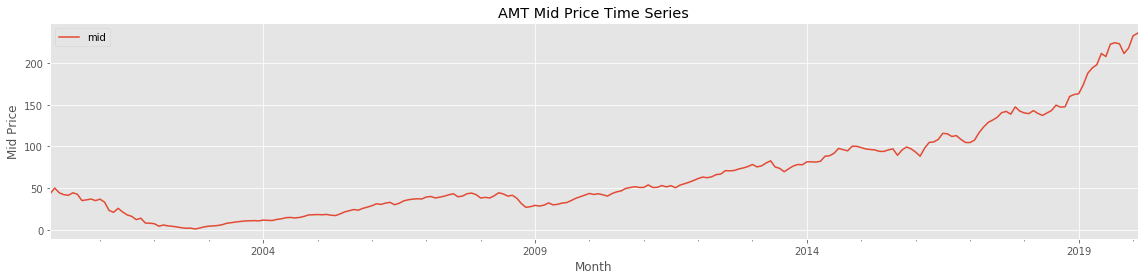

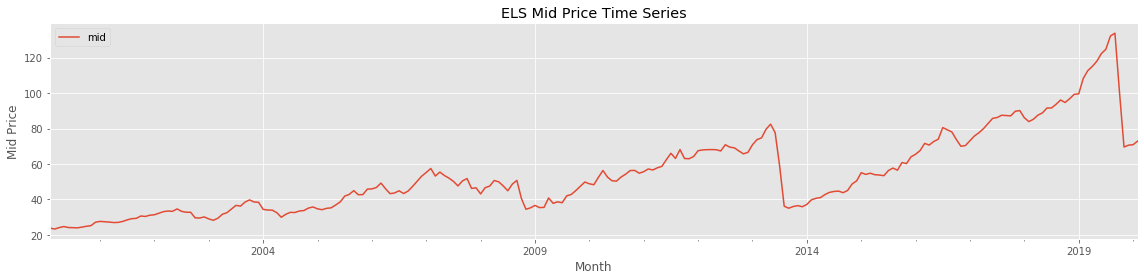

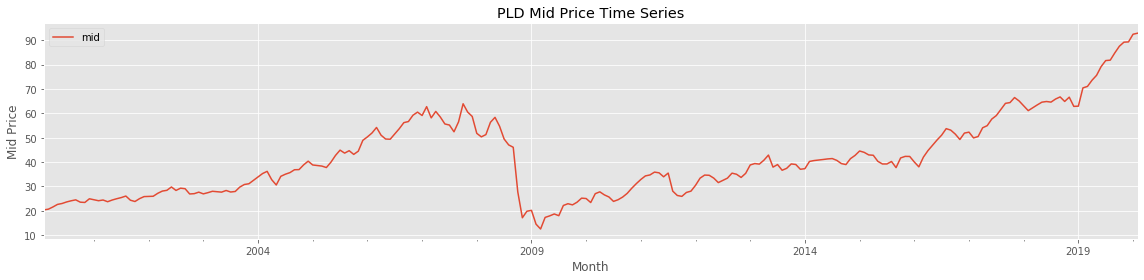

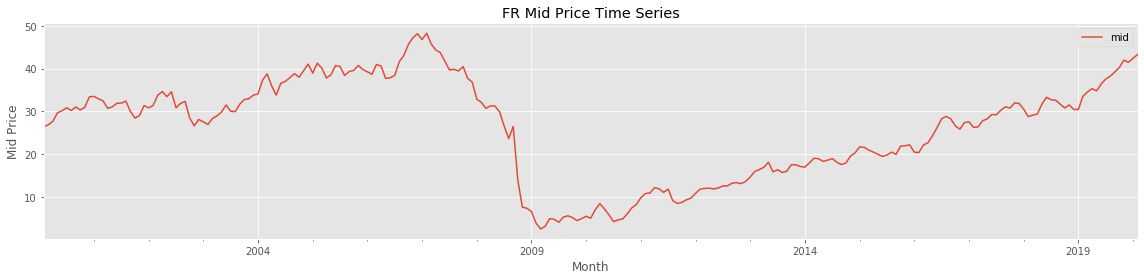

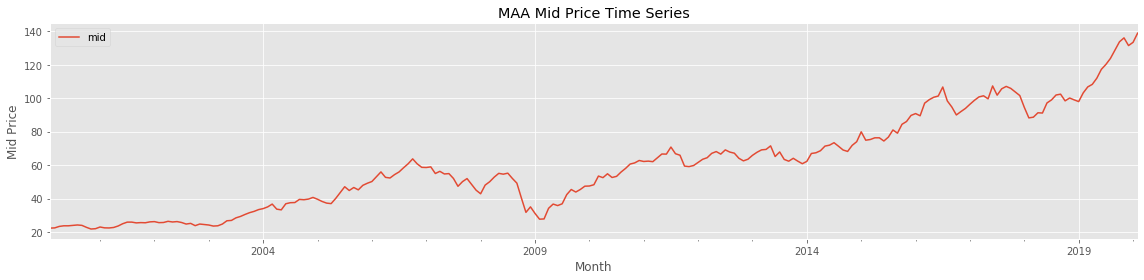

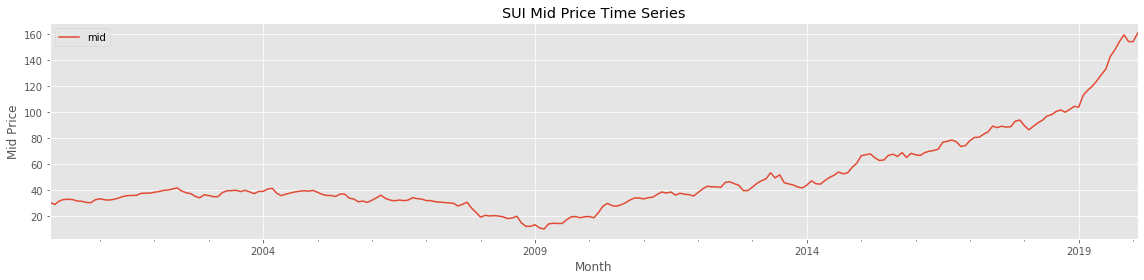

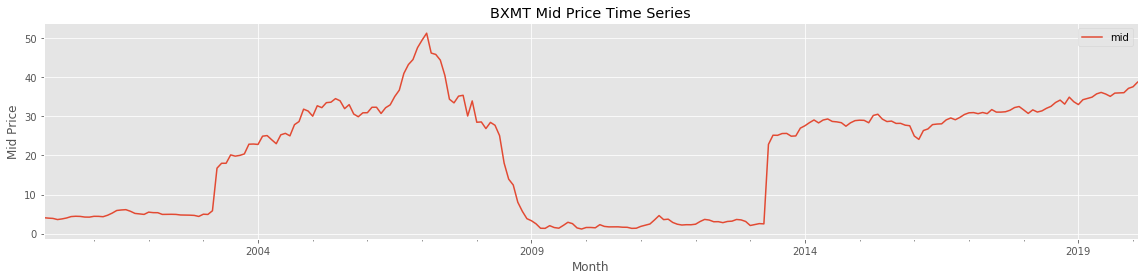

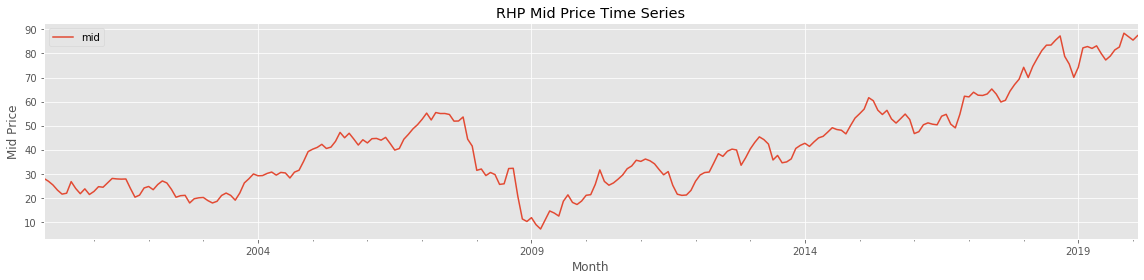

In [91]:
plot_reit_ts(reit_df_dict)

In [92]:
def decomposition(df_dict):
    for key in df_dict.keys():
        ts = df_dict[key]
        decomposition = seasonal_decompose(np.log(ts))
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid

        # Plot with subplots
        plt.figure(figsize=(10,6))
        plt.subplot(411)
        plt.plot(np.log(ts), label='Original', color="blue")
        plt.legend(loc='best')
        plt.title(f'{key}')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color="blue")
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color="blue")
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color="blue")
        plt.legend(loc='best')
        plt.tight_layout()
        

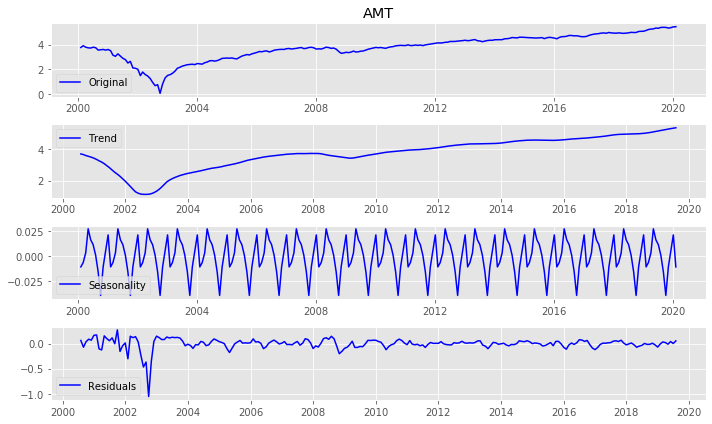

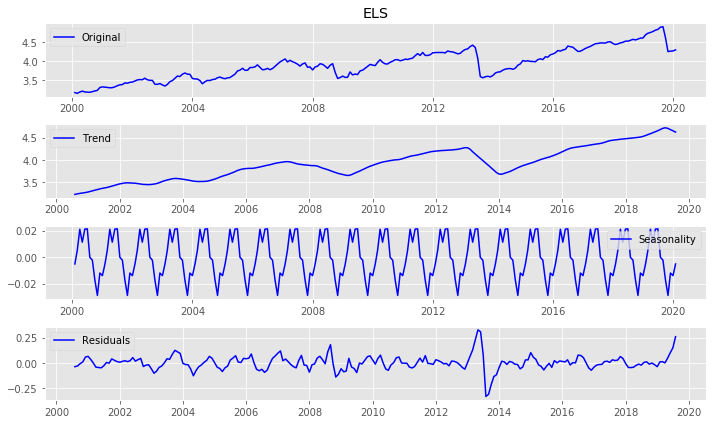

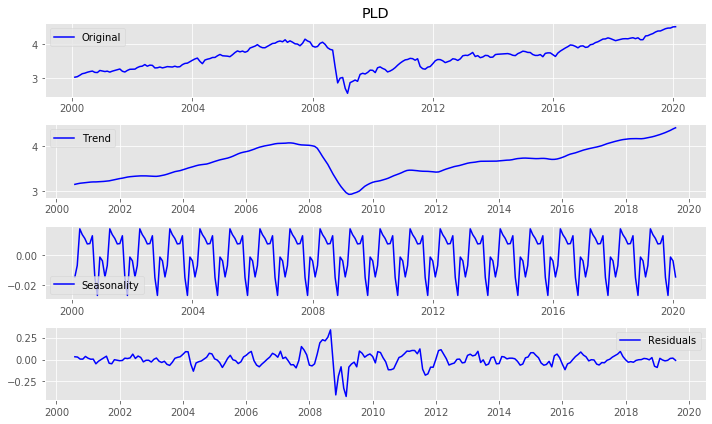

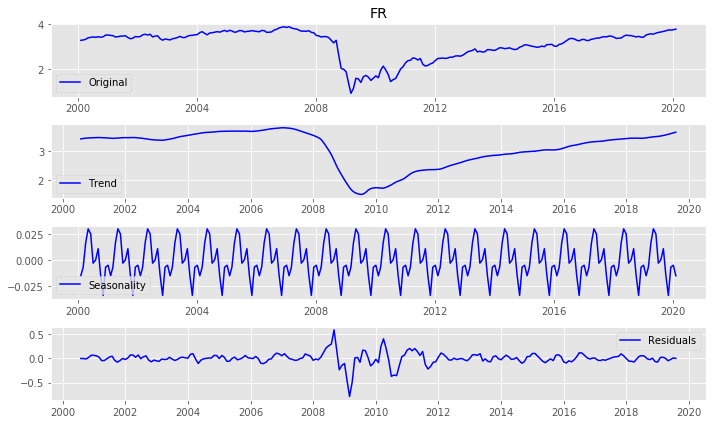

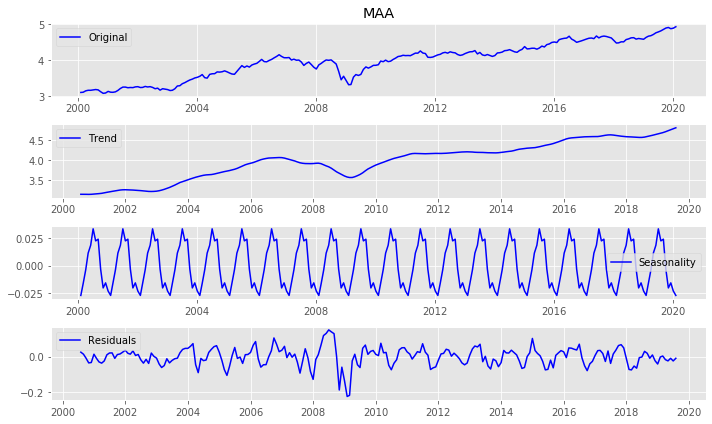

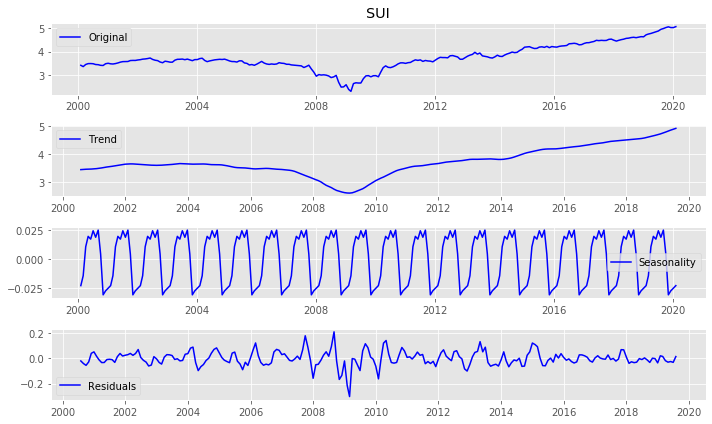

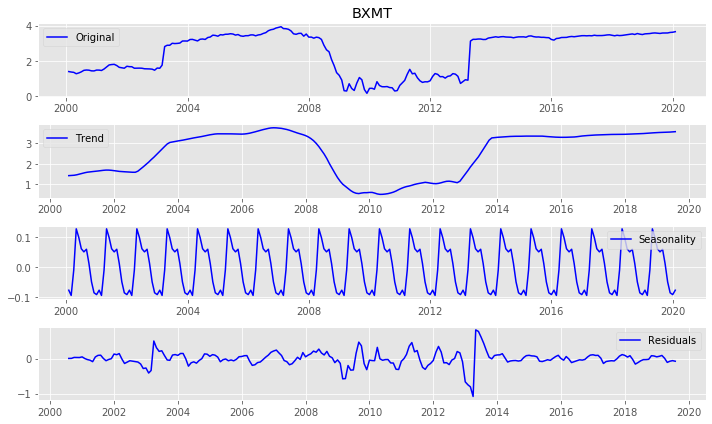

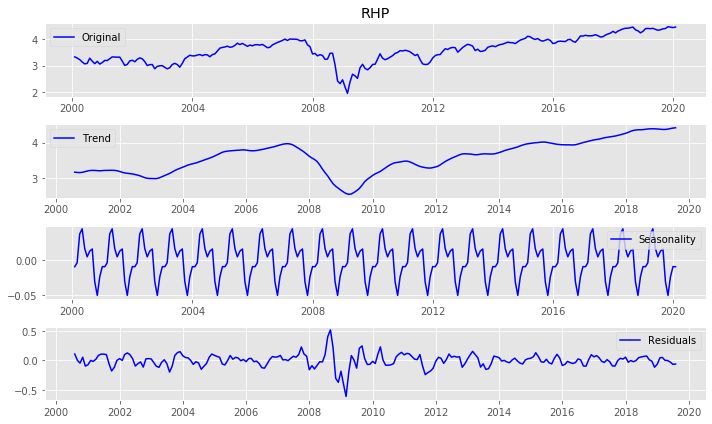

In [93]:
decomposition(reit_df_dict)

In [94]:
def differencing(df_dict):
    diff_df_dict = {}
    for key in df_dict.keys():
        diff_df_dict[key] = df_dict[key].diff(periods = 1).dropna()
        
    return diff_df_dict

In [95]:
#First order difference
diff1_reit_df_dict = differencing(reit_df_dict)

In [96]:
def dickey_fuller(df_dict):
    dftest_pvalue_dict = {}
    for key in df_dict.keys():
        dftest = adfuller(df_dict[key]['mid'])
        dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', '# lags used', '# Observations used'])
        dftest_pvalue_dict[key] = dftest[1]
        
    print(f'{((np.array(list(dftest_pvalue_dict.values())) < 0.05).sum() / len(df_dict)) * 100} % pass Dickey Fuller Test')
    return dftest_pvalue_dict

In [97]:
dickey_fuller(diff1_reit_df_dict)

87.5 % pass Dickey Fuller Test


{'AMT': 1.4210742132815765e-05,
 'ELS': 3.137624779001557e-19,
 'PLD': 1.465645847351546e-22,
 'FR': 0.006250804632937731,
 'MAA': 0.03586606504440696,
 'SUI': 0.4529319267630107,
 'BXMT': 9.048018961576989e-10,
 'RHP': 4.4278558998933344e-20}

## ACF/PACF

In [98]:
def plot_partial_autocorrelation(df_dict):
    for key in df_dict.keys():
        plot_pacf(df_dict[key], lags = 12)
        plt.title(f'PACF - {key}')
        plt.show();

In [99]:
def plot_autocorrelation(df_dict):
    for key in df_dict.keys():
        
        plot_acf(df_dict[key], lags = 12)
        plt.title(f'ACF - {key}')
        plt.show();

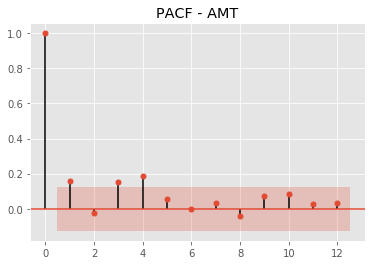

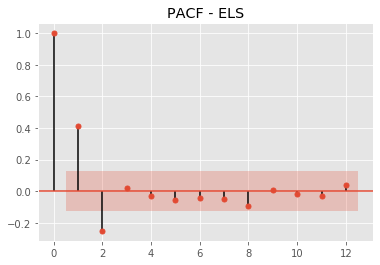

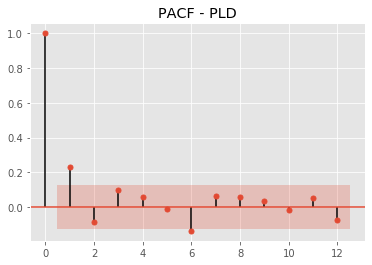

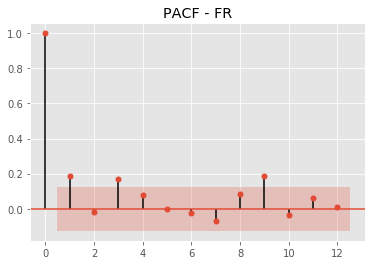

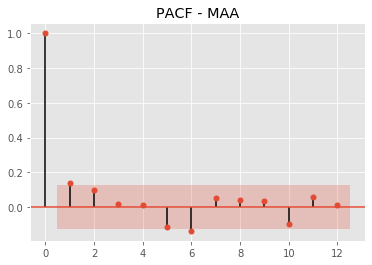

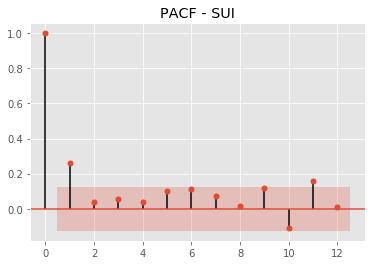

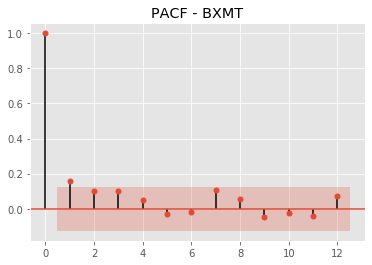

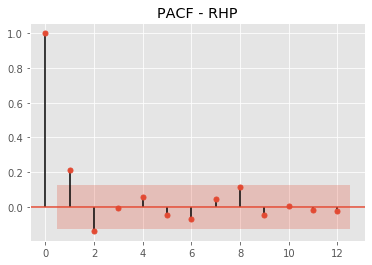

In [100]:
plot_partial_autocorrelation(diff1_reit_df_dict)

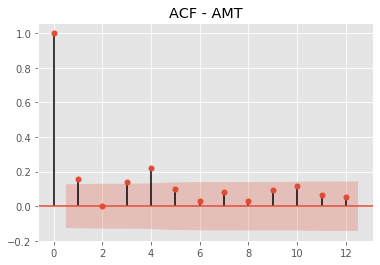

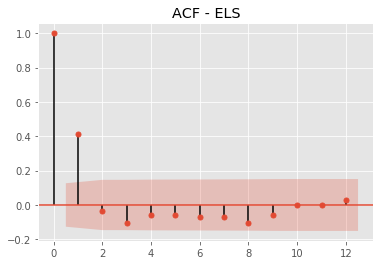

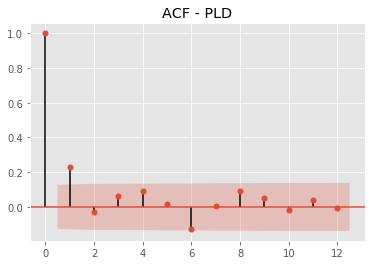

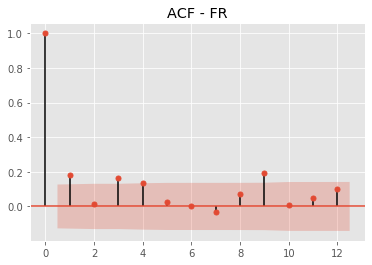

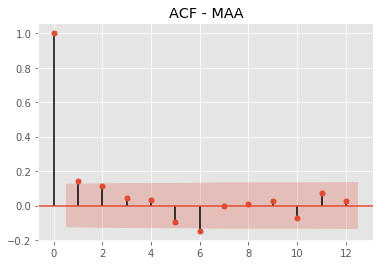

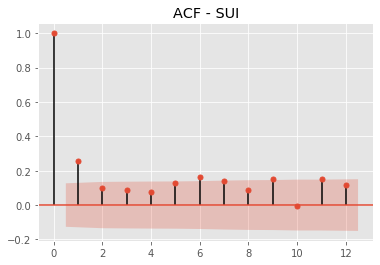

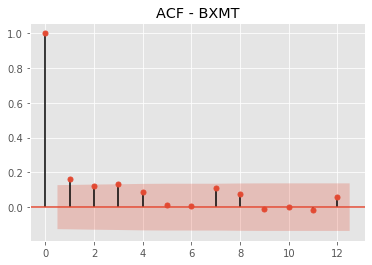

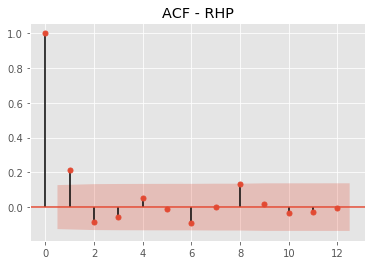

In [101]:
plot_autocorrelation(diff1_reit_df_dict)

## Parameters

In [139]:
best_parameters1 = {}
for key in diff1_reit_df_dict.keys():
    best_parameters1['AMT'] = (3,1,3)
    best_parameters1['ELS'] = (2,1,1)
    best_parameters1['PLD'] = (2,1,1)
    best_parameters1['FR'] = (3,1,3)
    best_parameters1['MAA'] = (2,1,2)
    best_parameters1['SUI'] = (1,1,1)
    best_parameters1['BXMT'] = (1,1,1)
    best_parameters1['RHP'] = (2,1,1)


In [140]:
best_seasonal_parameters1 = {}
for key in diff1_reit_df_dict.keys():
    best_seasonal_parameters1['AMT'] = (3,1,3, 12)
    best_seasonal_parameters1['ELS'] = (2,1,1, 12)
    best_seasonal_parameters1['PLD'] = (2,1,0, 12)
    best_seasonal_parameters1['FR'] = (3,1,3, 12)
    best_seasonal_parameters1['MAA'] = (2,1,2, 12)
    best_seasonal_parameters1['SUI'] = (1,1,1, 12)
    best_seasonal_parameters1['BXMT'] = (1,1,1, 12)
    best_seasonal_parameters1['RHP'] = (2,1,1, 12)

## SARIMAX #2 (No Exog)

In [167]:
best_parameters2 = {}
for key in diff1_reit_df_dict.keys():
    best_parameters2[key] = ()
    
best_parameters2['AMT'] = (3,1,2)
best_parameters2['ELS'] = (1,1,1)
best_parameters2['PLD'] = (1,1,2)
best_parameters2['FR'] = (3,1,2)
best_parameters2['MAA'] = (3,1,2)
best_parameters2['SUI'] = (3,1,3)
best_parameters2['BXMT'] = (2,1,2)
best_parameters2['RHP'] = (3,1,2)

best_seasonal_parameters2 = {}
for key in diff1_reit_df_dict.keys():
    best_seasonal_parameters2[key] = ()
    
best_seasonal_parameters2['AMT'] = (3,1,2, 12)
best_seasonal_parameters2['ELS'] = (1,1,1, 12)
best_seasonal_parameters2['PLD'] = (1,1,2, 12)
best_seasonal_parameters2['FR'] = (3,1,2, 12)
best_seasonal_parameters2['MAA'] = (3,1,2, 12)
best_seasonal_parameters2['SUI'] = (3,1,3, 12)
best_seasonal_parameters2['BXMT'] = (2,1,2, 12)
best_seasonal_parameters2['RHP'] = (3,1,2, 12)

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -513.119
Date:                            Thu, 06 Feb 2020   AIC                           1050.237
Time:                                    14:34:41   BIC                           1089.138
Sample:                                02-01-2000   HQIC                          1065.997
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0025      0.002      1.185      0.236      -0.002       0.007
ar.L1          0.5613  

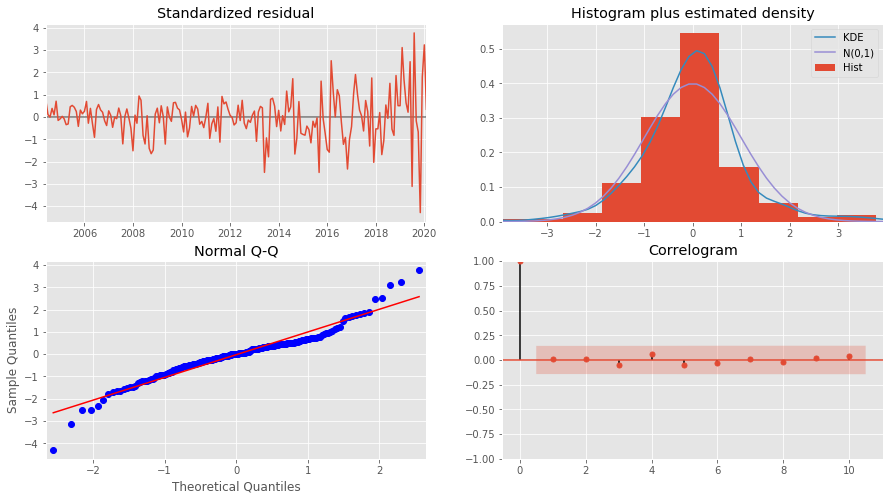

---------------------------------------------------------------
ELS Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -601.601
Date:                            Thu, 06 Feb 2020   AIC                           1215.201
Time:                                    14:34:44   BIC                           1235.397
Sample:                                02-01-2000   HQIC                          1223.362
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0001      0.001     -

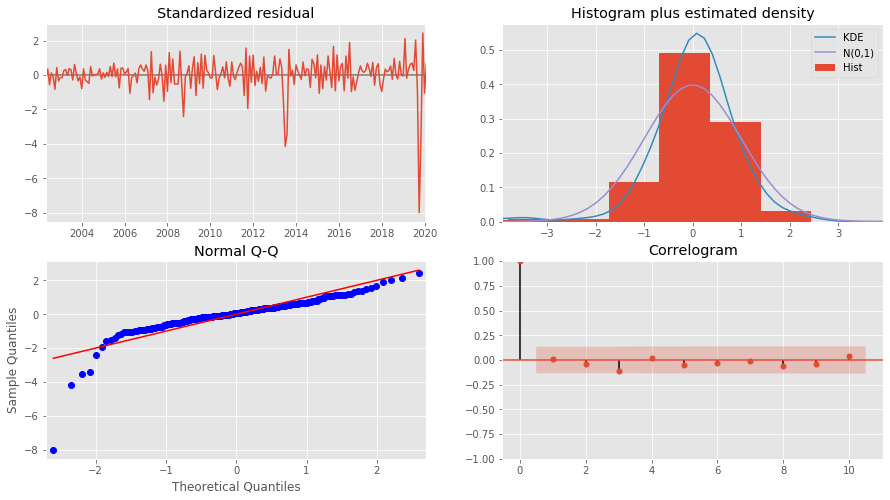

---------------------------------------------------------------
PLD Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -487.577
Date:                            Thu, 06 Feb 2020   AIC                            991.154
Time:                                    14:34:49   BIC                           1017.581
Sample:                                02-01-2000   HQIC                          1001.847
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0005      0.001      

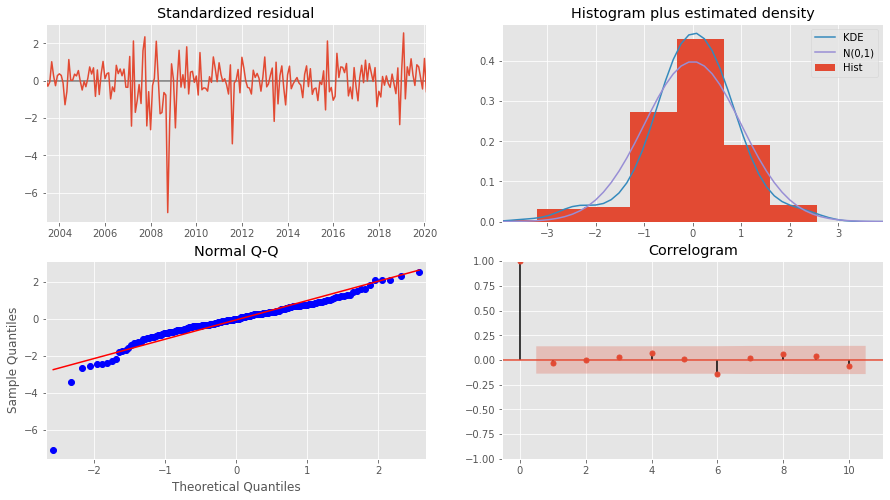

---------------------------------------------------------------
FR Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -365.377
Date:                            Thu, 06 Feb 2020   AIC                            754.754
Time:                                    14:35:04   BIC                            793.655
Sample:                                02-01-2000   HQIC                           770.513
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0006      0.001      1

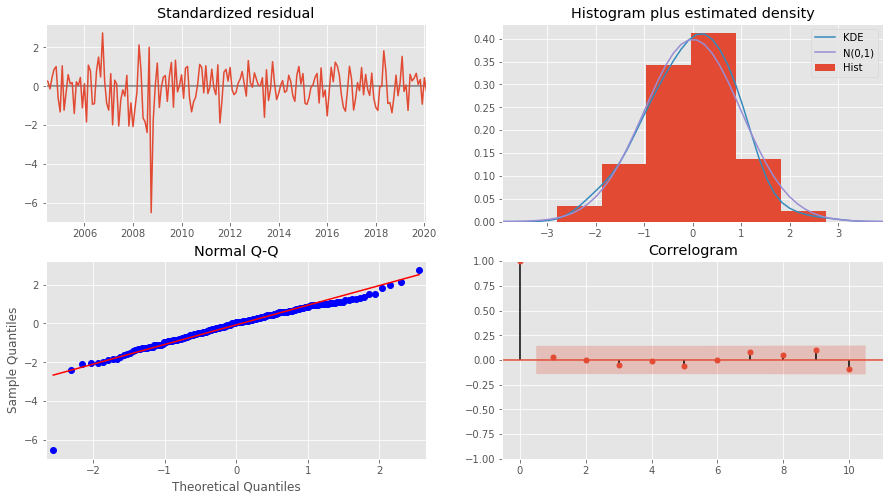

---------------------------------------------------------------
MAA Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -482.823
Date:                            Thu, 06 Feb 2020   AIC                            989.645
Time:                                    14:35:17   BIC                           1028.546
Sample:                                02-01-2000   HQIC                          1005.405
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0025      0.002      

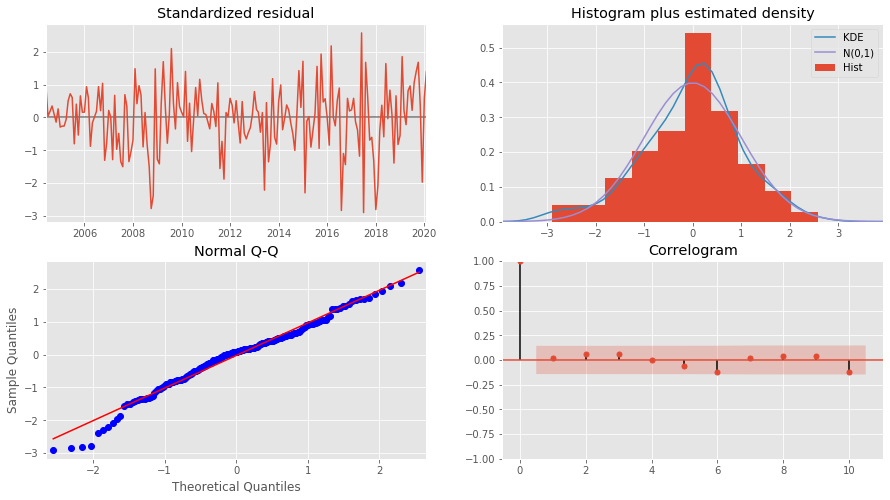

---------------------------------------------------------------
SUI Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -430.250
Date:                            Thu, 06 Feb 2020   AIC                            888.501
Time:                                    14:35:34   BIC                            933.811
Sample:                                02-01-2000   HQIC                           906.859
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0048      0.005      

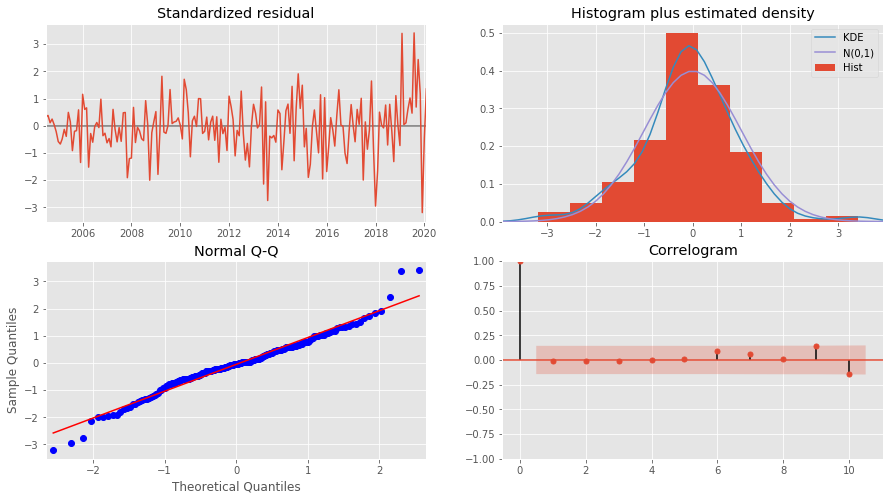

---------------------------------------------------------------
BXMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -486.472
Date:                            Thu, 06 Feb 2020   AIC                            992.944
Time:                                    14:35:41   BIC                           1025.977
Sample:                                02-01-2000   HQIC                          1006.311
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       6.626e-06      0.000     

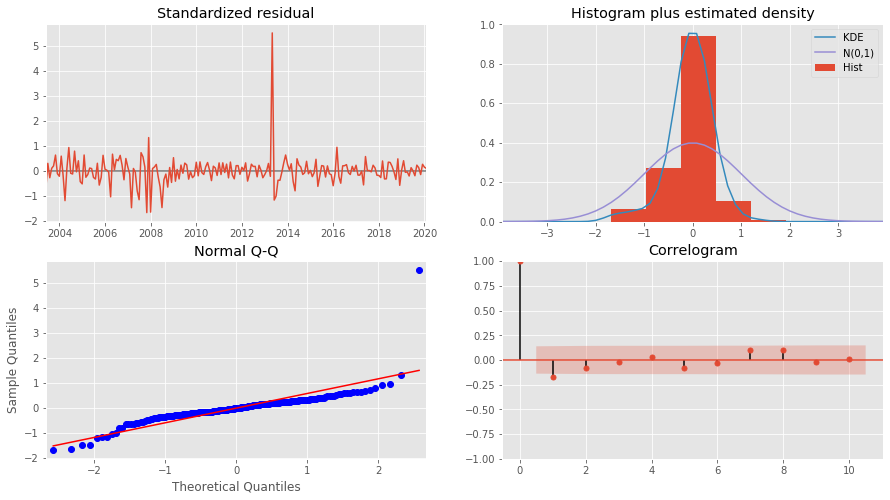

---------------------------------------------------------------
RHP Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  241
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -486.207
Date:                            Thu, 06 Feb 2020   AIC                            996.413
Time:                                    14:35:54   BIC                           1035.314
Sample:                                02-01-2000   HQIC                          1012.173
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0007      0.001      

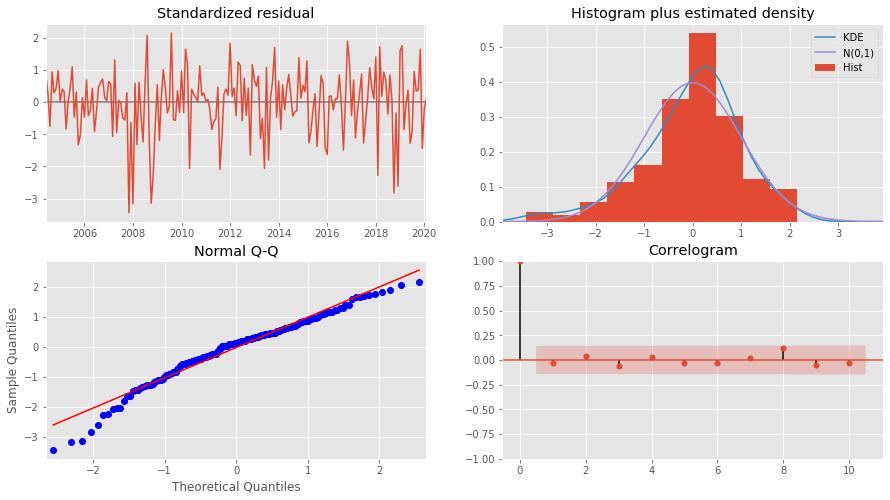

---------------------------------------------------------------


In [143]:
results_dict = {}
for key in reit_df_dict.keys():
    ts = reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, order = best_parameters2[key],
                                            seasonal_order = best_seasonal_parameters2[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    results_dict[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

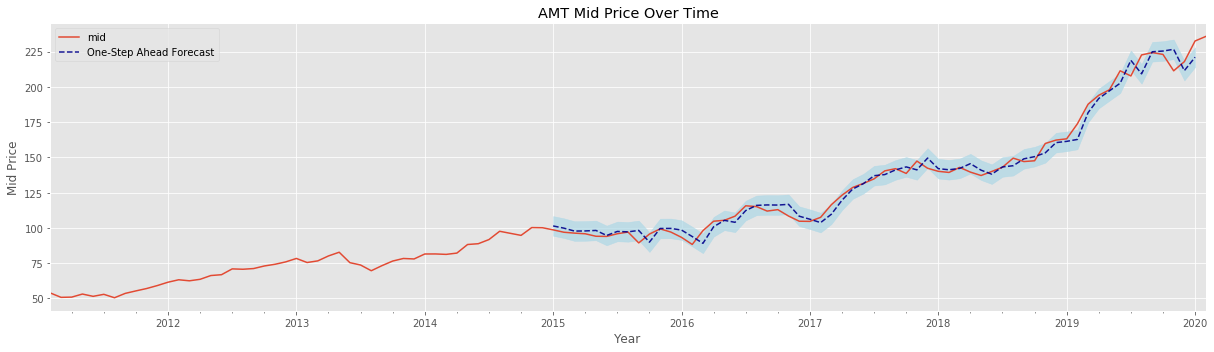

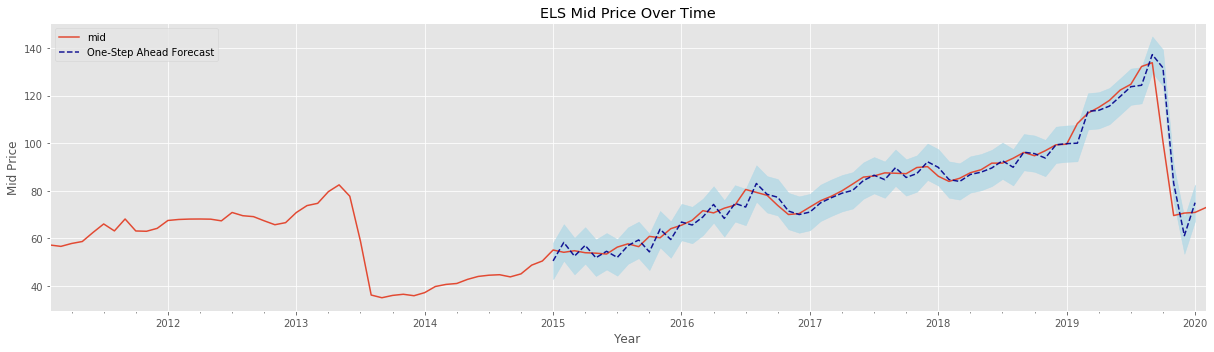

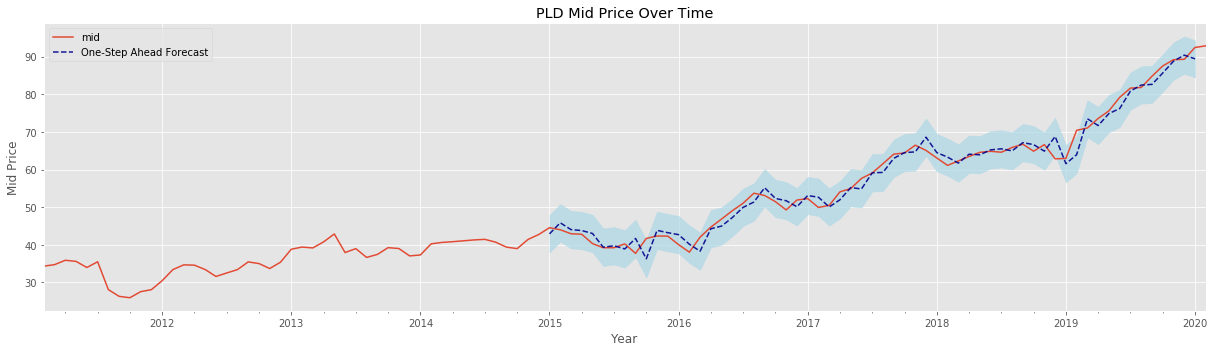

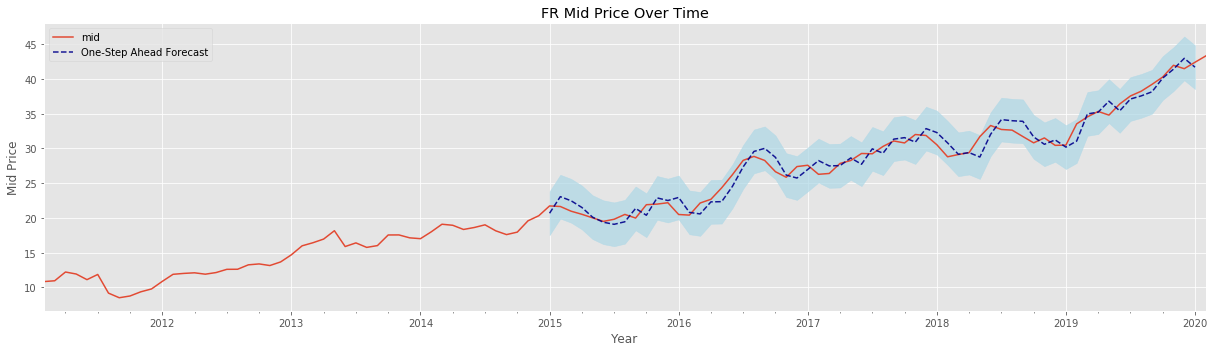

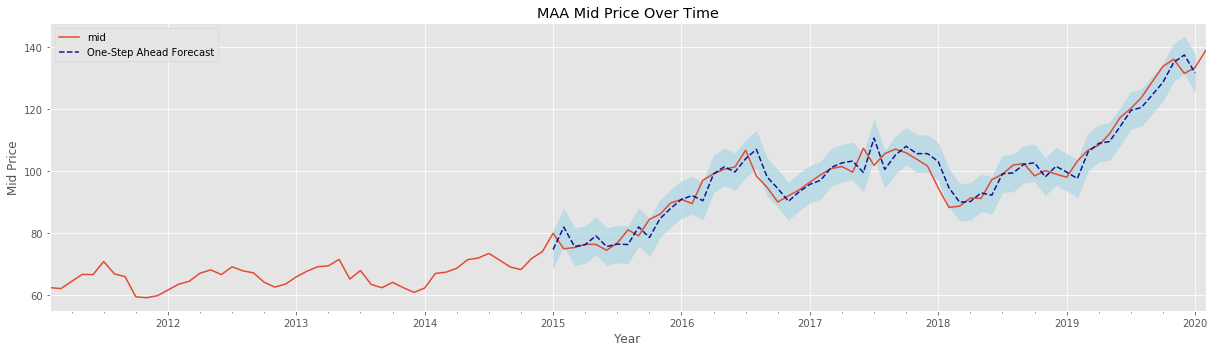

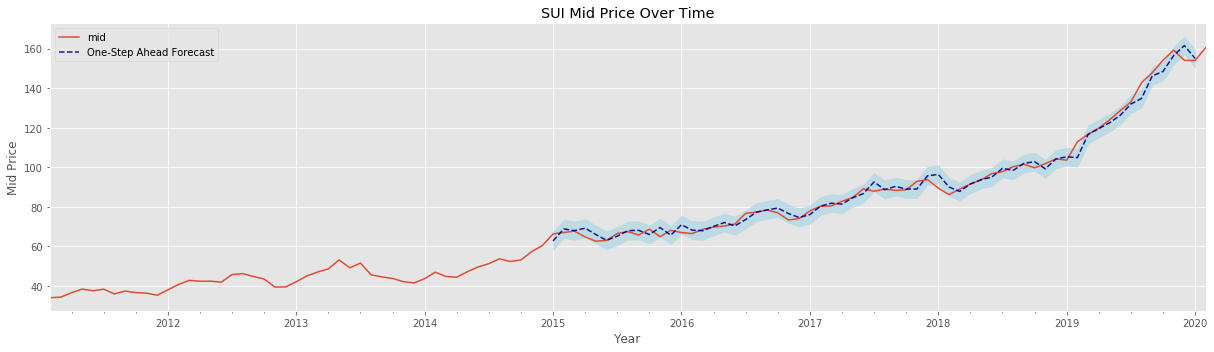

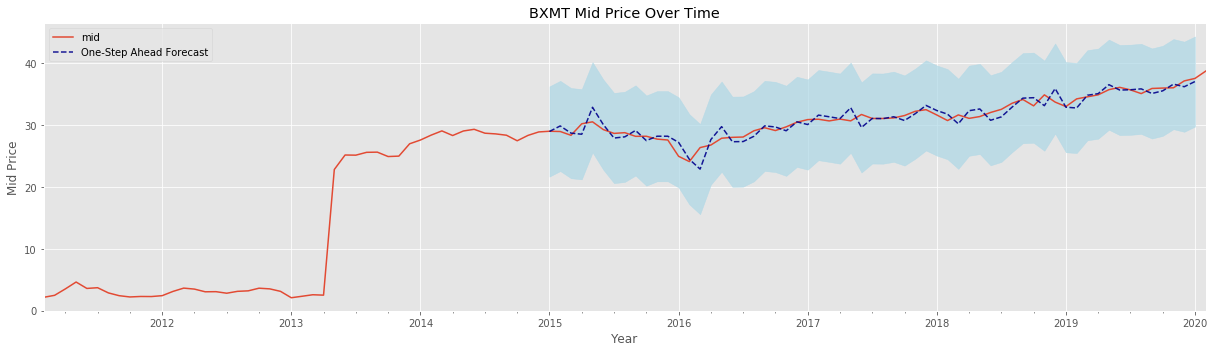

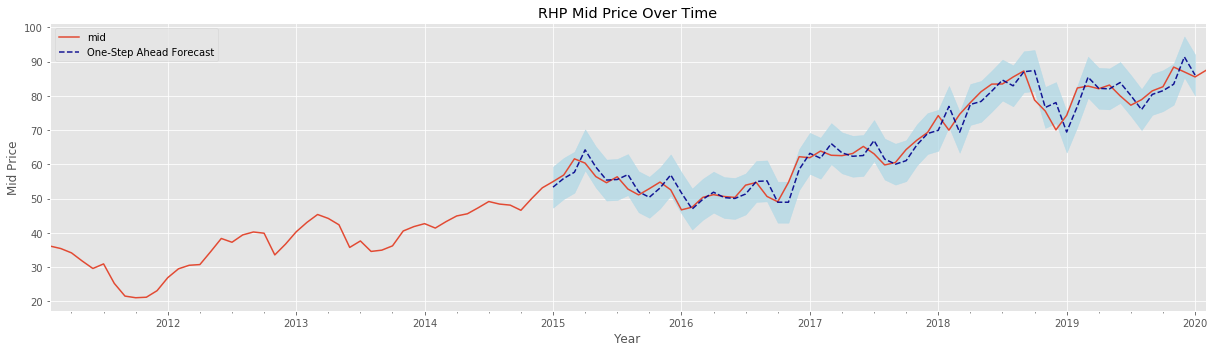

In [158]:
## Get predictions starting from 2000 and display confidence intervals.
# Compare predictions to actual data 2000-2014
for key in results_dict.keys():
    results = results_dict[key]
    predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), end = pd.to_datetime('2020-01-01'), dynamic=False)
    pred_conf = predictions.conf_int()
    
    #Plot observed values
    ax = reit_df_dict[key]['2011-02-01':].plot(label='observed', figsize = (17,5))

    #Plot predicted values
    predictions.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.9, color = 'darkblue', style = '--')

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

    #Set axes labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Mid Price')
    plt.legend(loc = 'upper left')
    plt.title(f'{key} Mid Price Over Time')
    plt.tight_layout()
    plt.show()
    

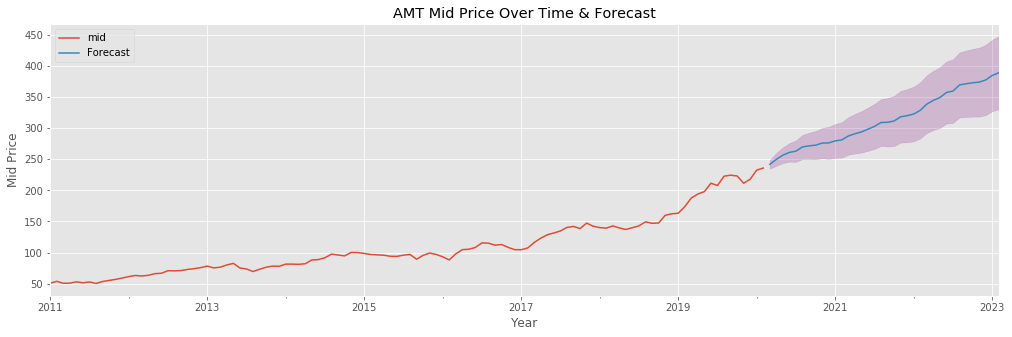

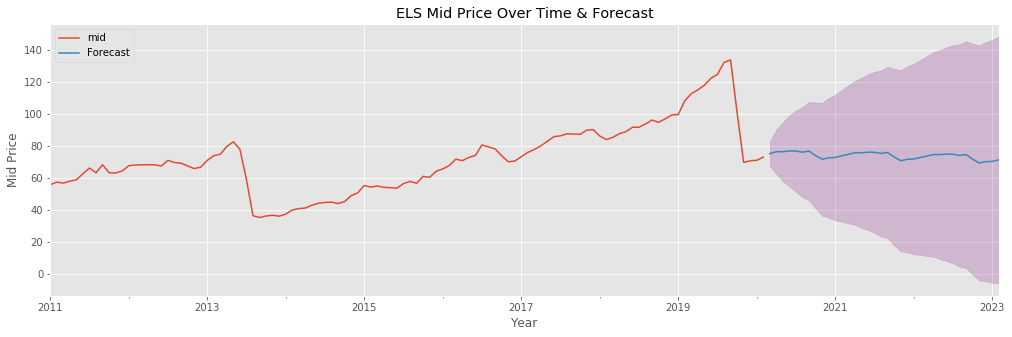

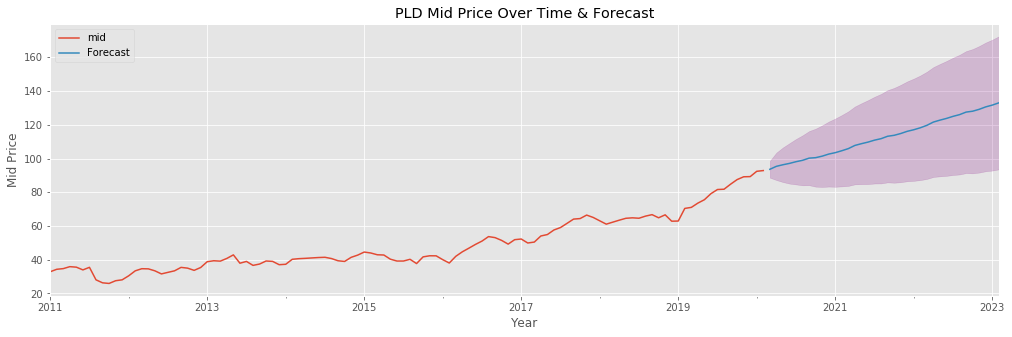

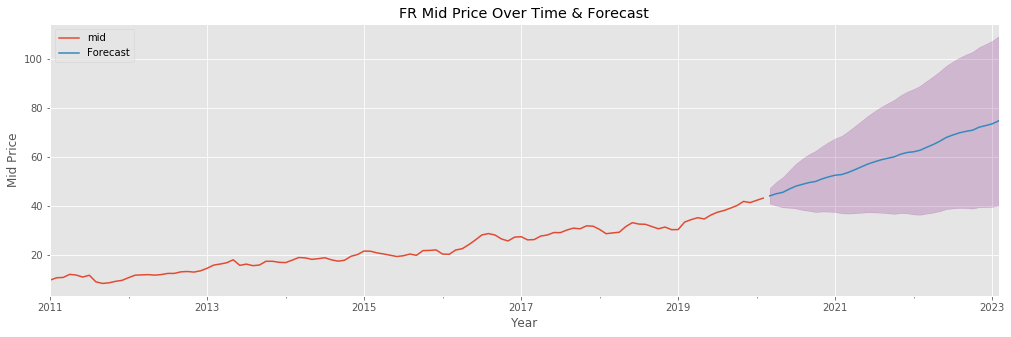

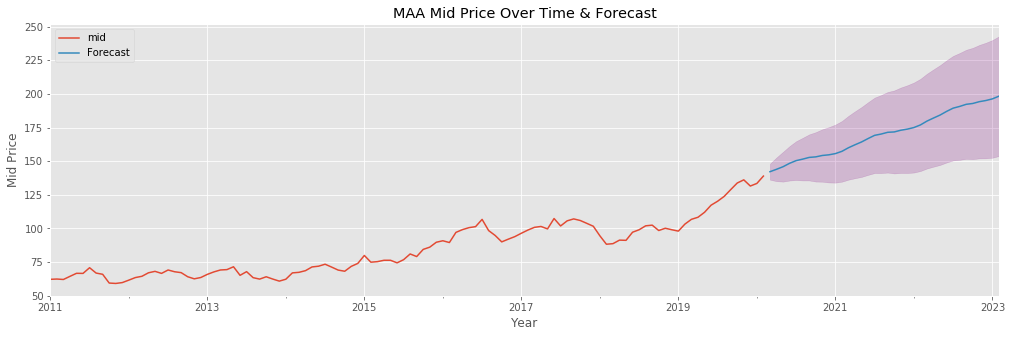

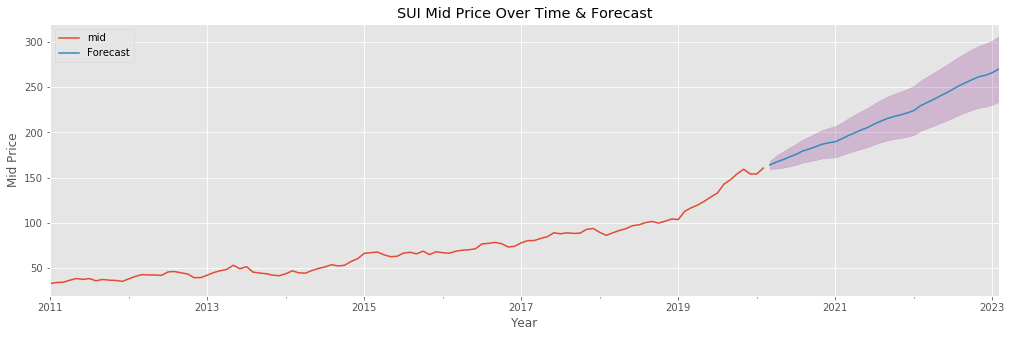

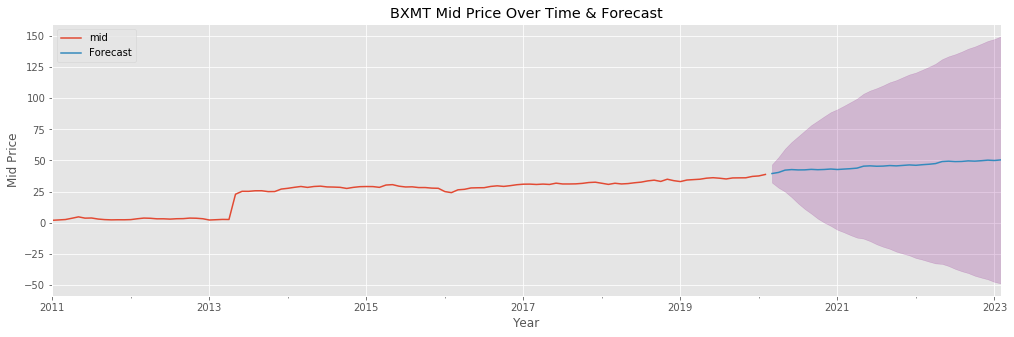

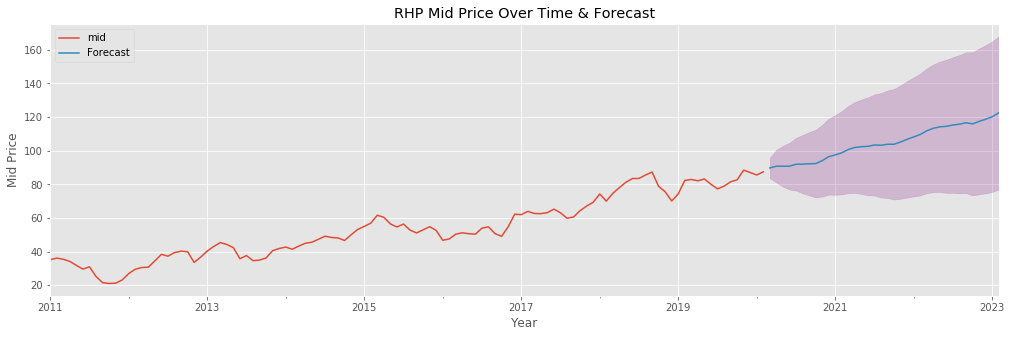

In [179]:
for key in results_dict.keys():
    results = results_dict[key]
    prediction = results.get_forecast(steps = 36)
    pred_conf = prediction.conf_int()
    
    ax = reit_df_dict[key]['2011-01-01':].plot(label = 'observed', figsize = (17,5))
    prediction.predicted_mean.plot(ax=ax, label = 'Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1],
                    color = 'purple', alpha = .20)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Mid Price')
    plt.title(f"{key} Mid Price Over Time & Forecast")
    plt.legend(loc = 'upper left')
    plt.show()
    

## Exogenous Gathering

In [107]:
fred = Fred(api_key = 'aec5f13aa40d1af4edd587ffccceeb1a')
libor = fred.get_series('USD1MTD156N', start, end)
libor_monthly = round(libor.resample('MS').mean(),2)
libor_monthly = pd.DataFrame(libor_monthly, index = libor_monthly.index, columns = ['rate'])

In [108]:
libor_train = libor_monthly[:'2015']
libor_test = libor_monthly['2016':]

## SARIMAX #1 + Exog

In [109]:
train_reit_df_dict = {}
test_reit_df_dict = {}
for key in reit_df_dict.keys():
    train = reit_df_dict[key][:'2015']
    test = reit_df_dict[key]['2016':]
    train_reit_df_dict[key] = train
    test_reit_df_dict[key] = test

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -315.860
Date:                            Thu, 06 Feb 2020   AIC                            661.721
Time:                                    09:47:49   BIC                            705.629
Sample:                                02-01-2000   HQIC                           679.564
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0.456      0.649      -0.001       0.002
rate           0.2171  

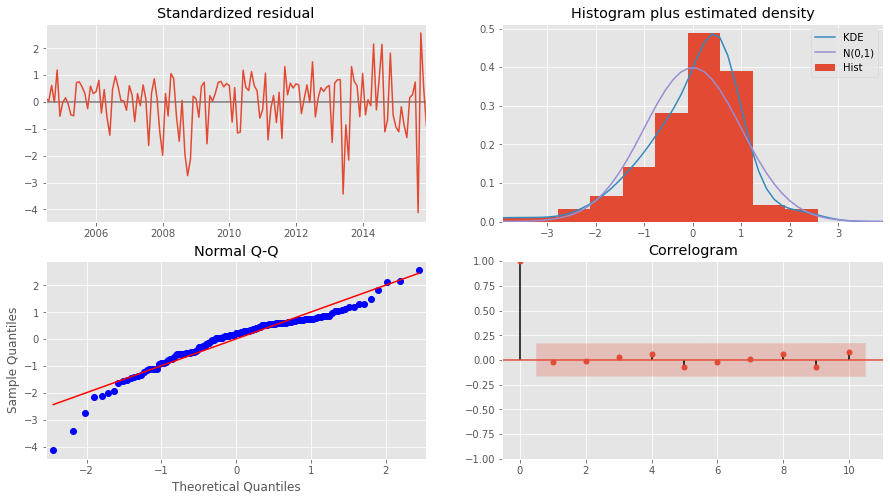

---------------------------------------------------------------
ELS Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -398.903
Date:                            Thu, 06 Feb 2020   AIC                            815.805
Time:                                    09:48:00   BIC                            843.020
Sample:                                02-01-2000   HQIC                           826.861
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -4.753e-05      0.001     -

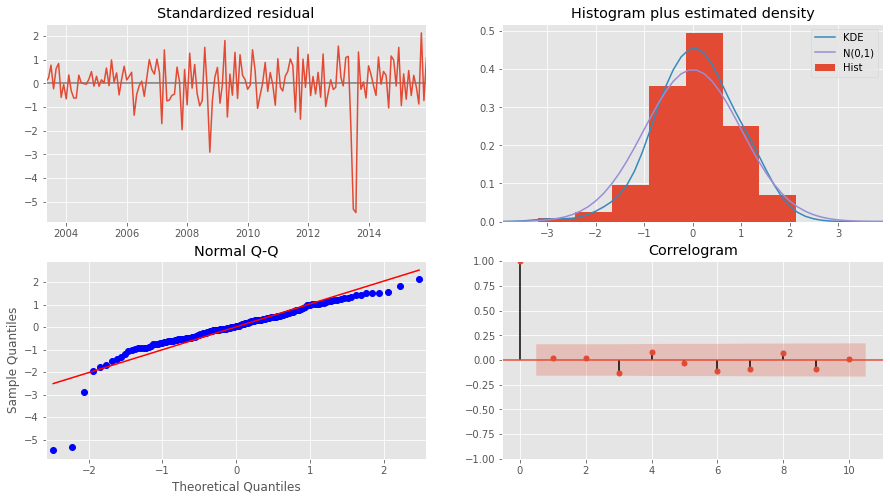

---------------------------------------------------------------
PLD Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -390.614
Date:                            Thu, 06 Feb 2020   AIC                            797.229
Time:                                    09:48:10   BIC                            821.420
Sample:                                02-01-2000   HQIC                           807.056
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -3.884e-05      0.004     -

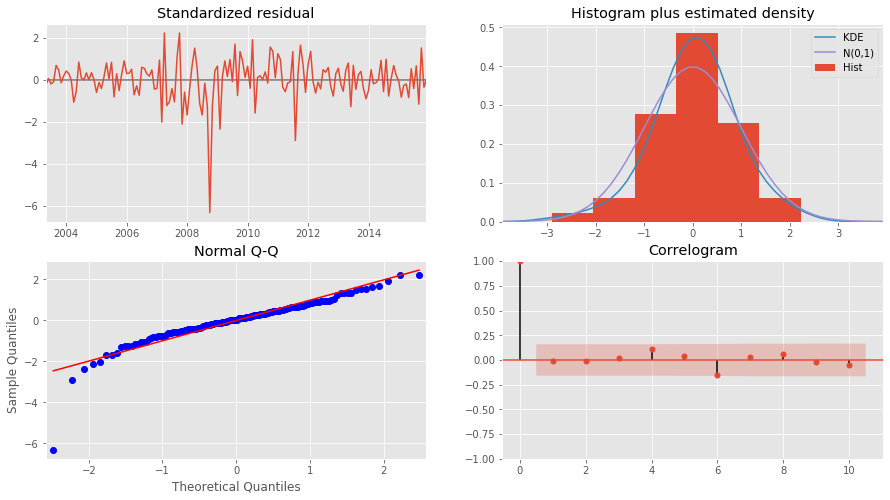

---------------------------------------------------------------
FR Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -274.928
Date:                            Thu, 06 Feb 2020   AIC                            579.856
Time:                                    09:48:34   BIC                            623.765
Sample:                                02-01-2000   HQIC                           597.700
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0

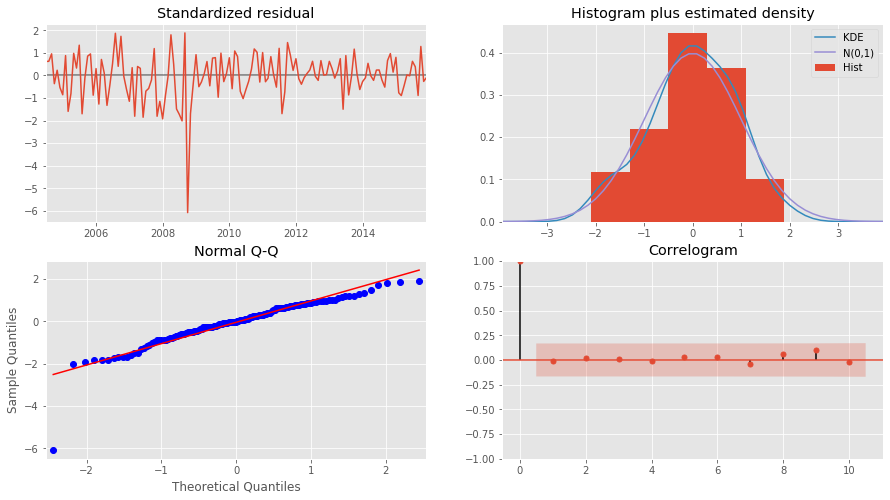

---------------------------------------------------------------
MAA Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -365.919
Date:                            Thu, 06 Feb 2020   AIC                            753.838
Time:                                    09:48:44   BIC                            787.028
Sample:                                02-01-2000   HQIC                           767.321
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0009      0.001      

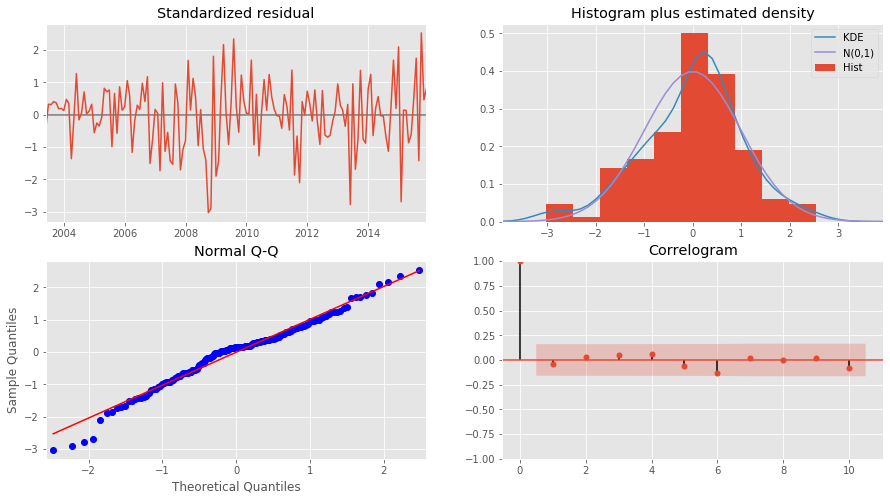

---------------------------------------------------------------
SUI Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -349.159
Date:                            Thu, 06 Feb 2020   AIC                            712.318
Time:                                    09:48:47   BIC                            734.017
Sample:                                02-01-2000   HQIC                           721.127
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0005      0.000      

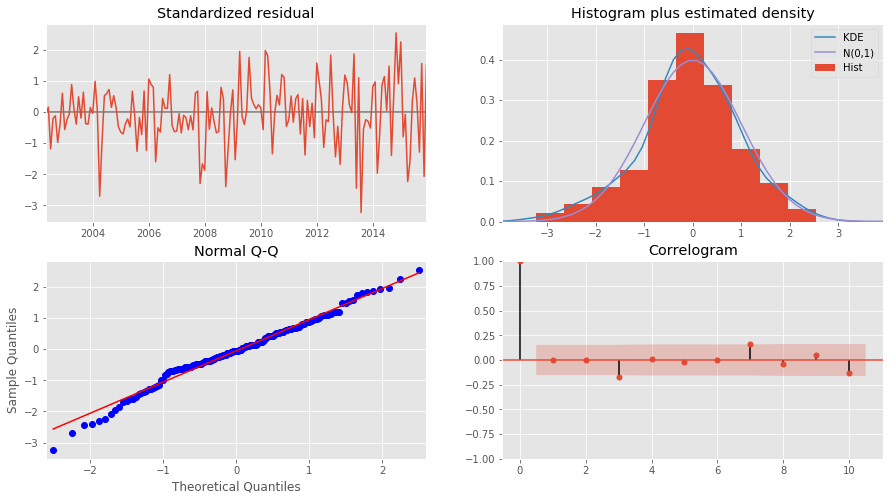

---------------------------------------------------------------
BXMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -382.518
Date:                            Thu, 06 Feb 2020   AIC                            779.037
Time:                                    09:48:50   BIC                            800.736
Sample:                                02-01-2000   HQIC                           787.846
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       4.996e-05      0.000     

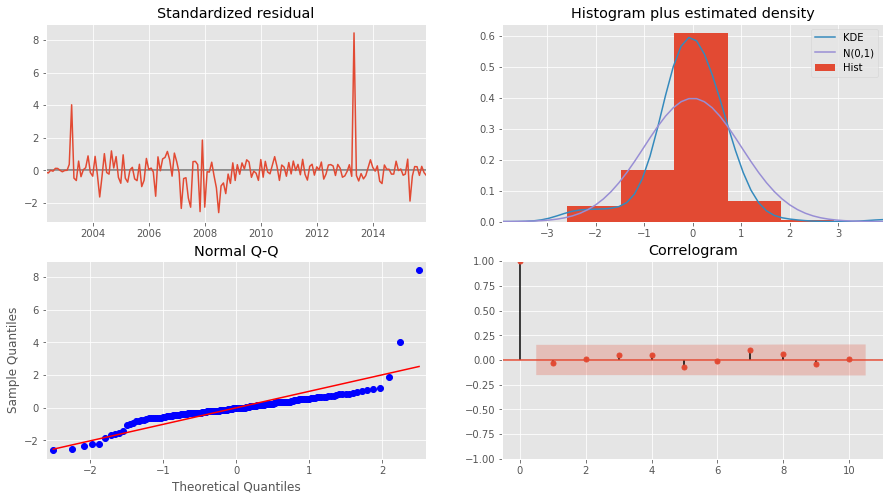

---------------------------------------------------------------
RHP Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -386.777
Date:                            Thu, 06 Feb 2020   AIC                            791.553
Time:                                    09:48:57   BIC                            818.768
Sample:                                02-01-2000   HQIC                           802.609
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.001      

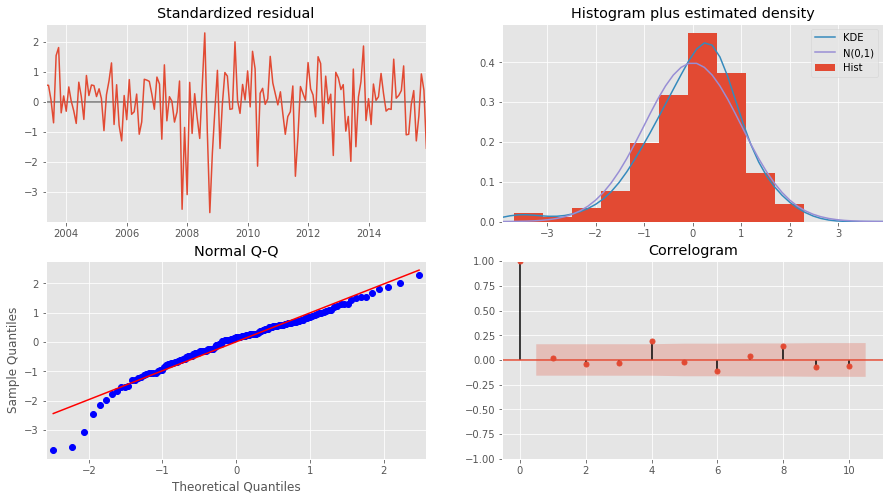

---------------------------------------------------------------


In [110]:
results_dict1 = {}
for key in train_reit_df_dict.keys():
    ts = train_reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, 
                                            exog = libor_train,
                                            order = best_parameters1[key],
                                            seasonal_order = best_seasonal_parameters1[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    results_dict1[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

## SARIMA #2 + Exog

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -319.588
Date:                            Thu, 06 Feb 2020   AIC                            665.176
Time:                                    09:49:13   BIC                            703.324
Sample:                                02-01-2000   HQIC                           680.678
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0002      0.001      0.331      0.741      -0.001       0.001
rate           0.1971  

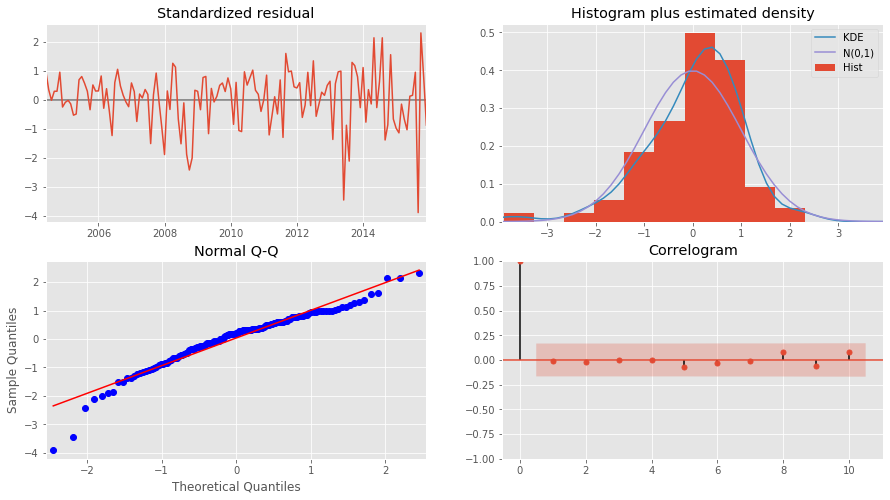

---------------------------------------------------------------
ELS Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -423.474
Date:                            Thu, 06 Feb 2020   AIC                            860.949
Time:                                    09:49:17   BIC                            882.648
Sample:                                02-01-2000   HQIC                           869.758
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       2.244e-05      0.001      

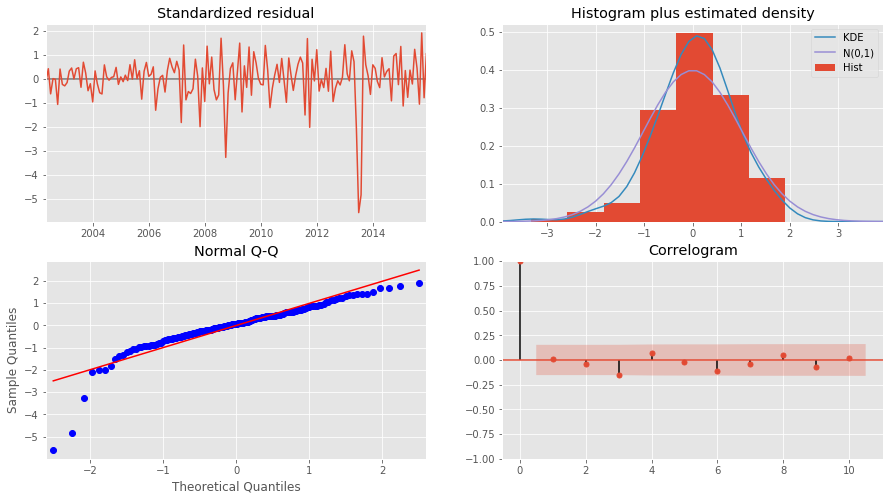

---------------------------------------------------------------
PLD Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -375.267
Date:                            Thu, 06 Feb 2020   AIC                            768.533
Time:                                    09:49:25   BIC                            795.689
Sample:                                02-01-2000   HQIC                           779.565
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0002      0.001     -

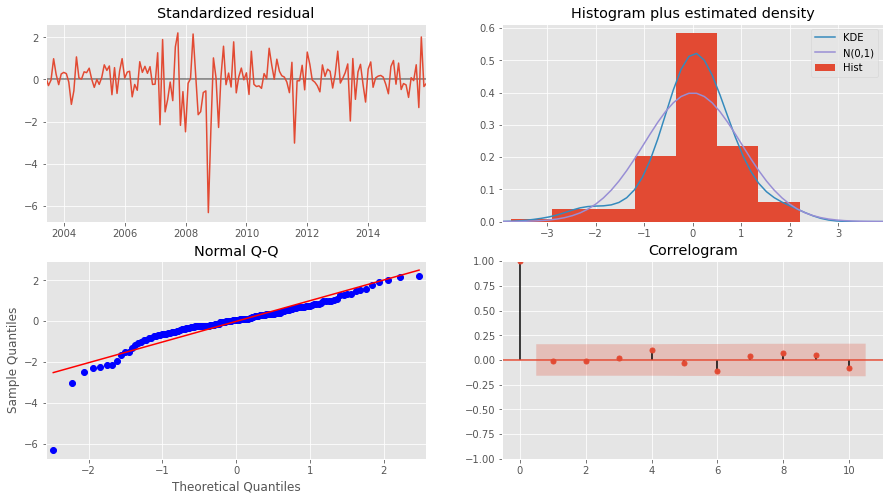

---------------------------------------------------------------
FR Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -282.345
Date:                            Thu, 06 Feb 2020   AIC                            590.689
Time:                                    09:49:48   BIC                            628.837
Sample:                                02-01-2000   HQIC                           606.192
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0001      0.000      0

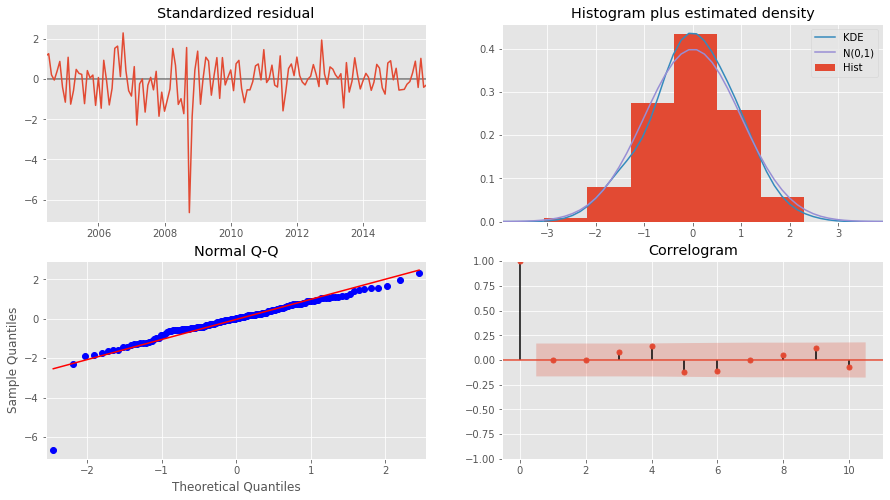

---------------------------------------------------------------
MAA Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -340.605
Date:                            Thu, 06 Feb 2020   AIC                            707.211
Time:                                    09:50:05   BIC                            745.359
Sample:                                02-01-2000   HQIC                           722.713
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0018      0.003      

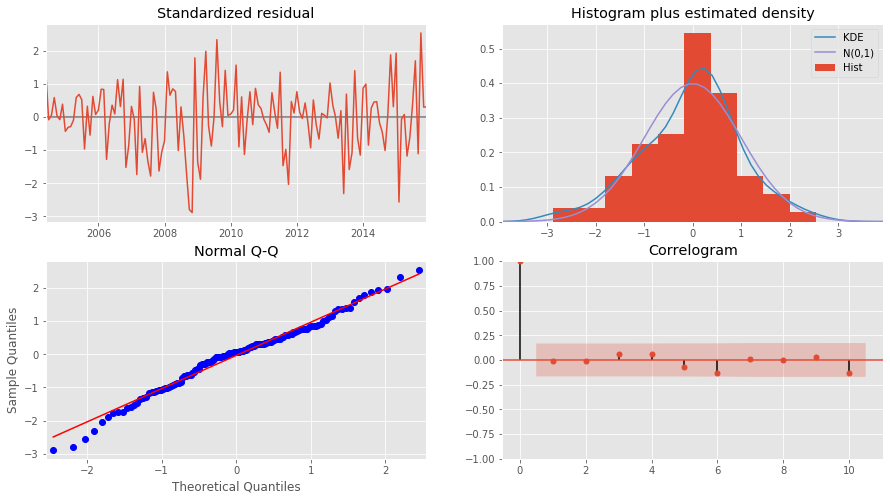

---------------------------------------------------------------
SUI Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -294.531
Date:                            Thu, 06 Feb 2020   AIC                            619.061
Time:                                    09:50:25   BIC                            662.970
Sample:                                02-01-2000   HQIC                           636.905
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0021      0.007      

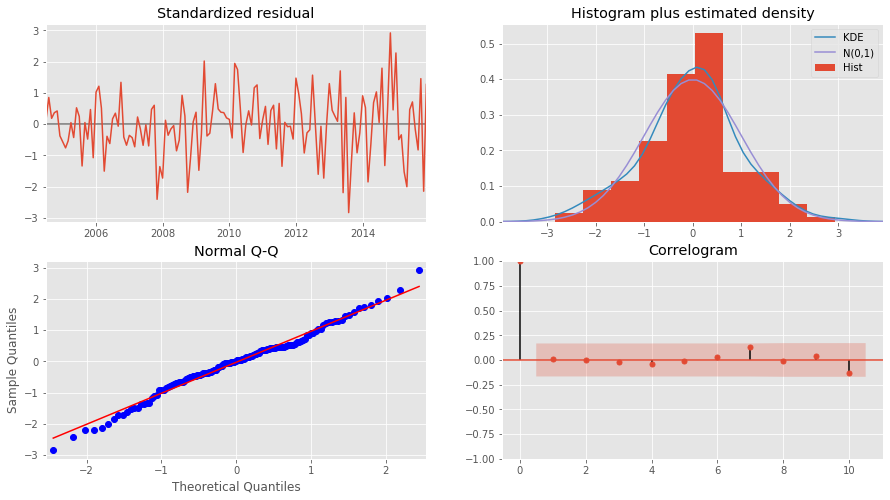

---------------------------------------------------------------
BXMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                -378.975
Date:                            Thu, 06 Feb 2020   AIC                            779.951
Time:                                    09:50:32   BIC                            813.141
Sample:                                02-01-2000   HQIC                           793.434
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0011      0.002     

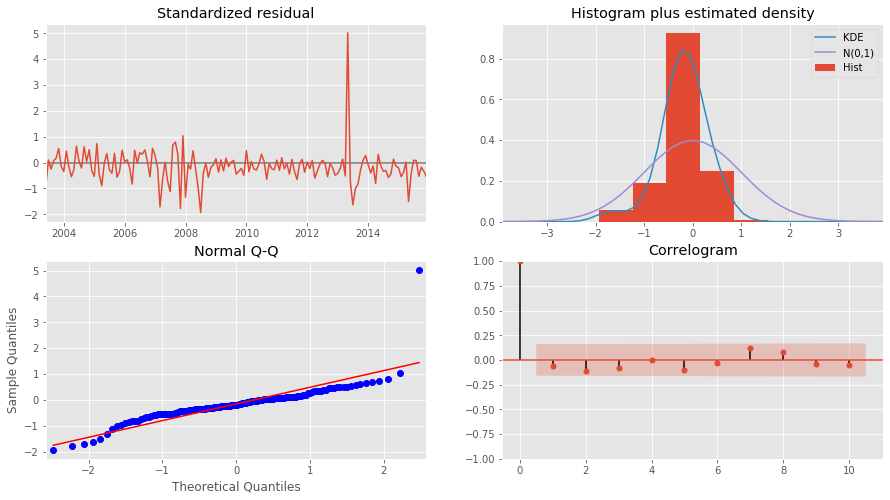

---------------------------------------------------------------
RHP Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -348.463
Date:                            Thu, 06 Feb 2020   AIC                            722.927
Time:                                    09:50:46   BIC                            761.075
Sample:                                02-01-2000   HQIC                           738.429
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0008      0.002      

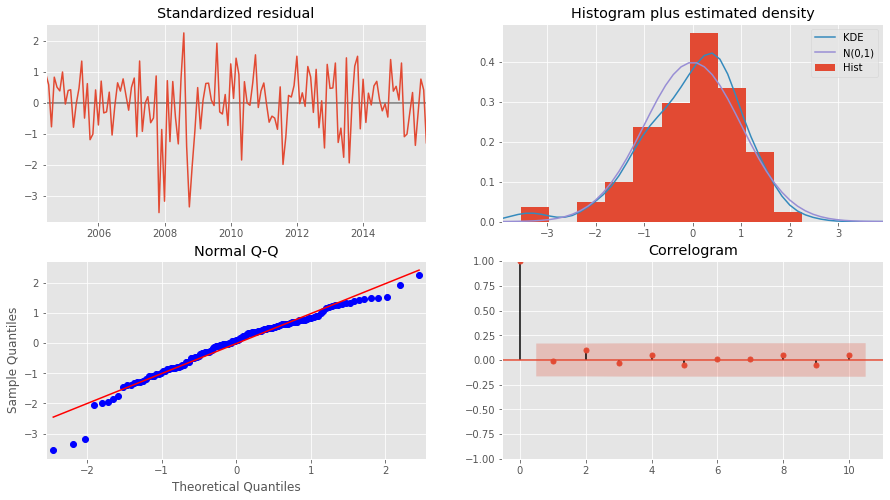

---------------------------------------------------------------


In [111]:
results_dict2 = {}
for key in train_reit_df_dict.keys():
    ts = train_reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, 
                                            exog = libor_train,
                                            order = best_parameters2[key],
                                            seasonal_order = best_seasonal_parameters2[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    results_dict2[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

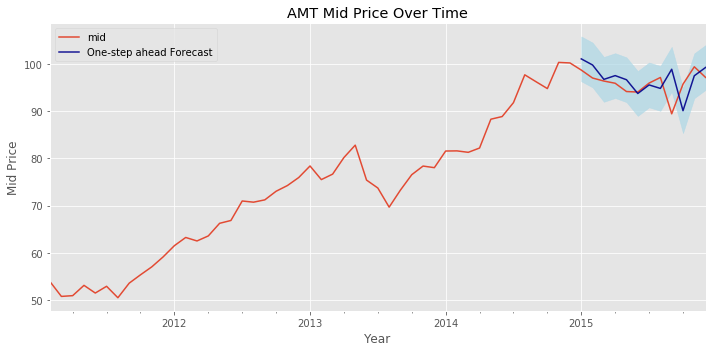

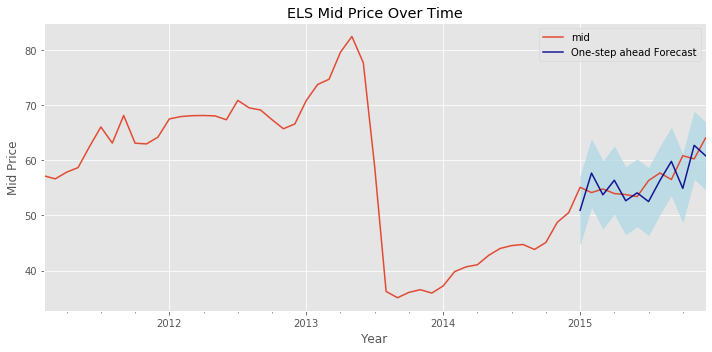

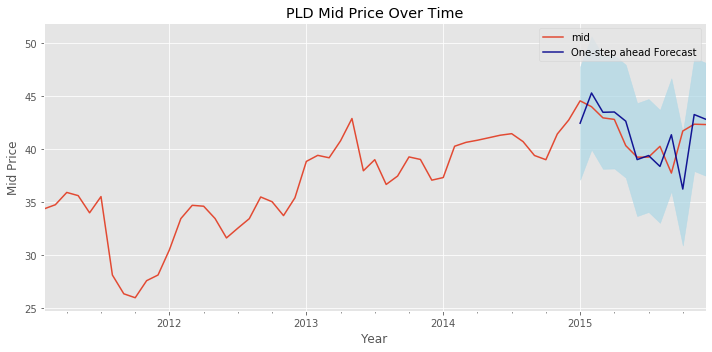

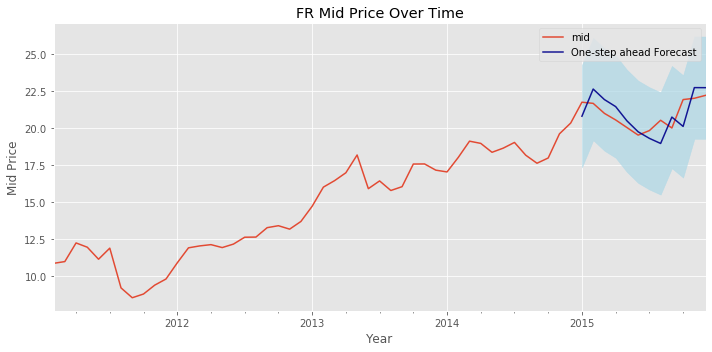

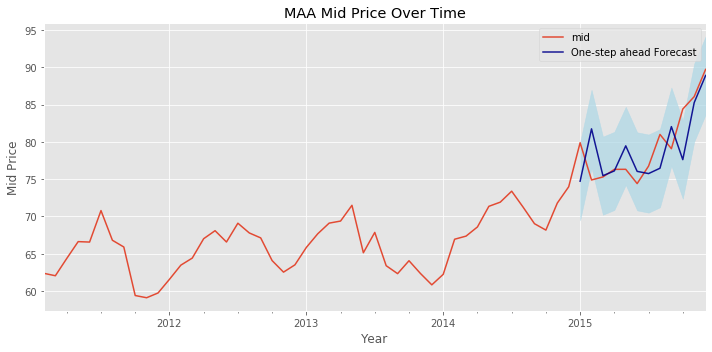

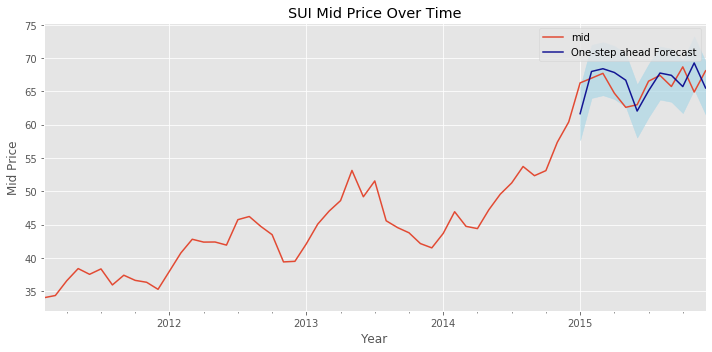

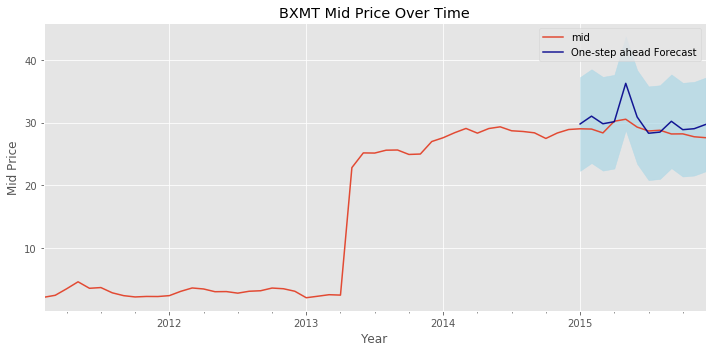

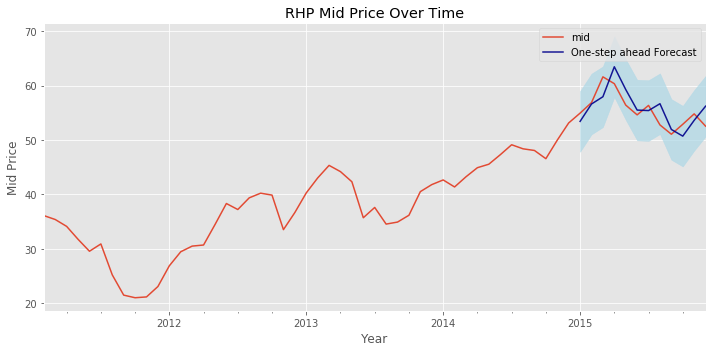

In [112]:
# Get predictions starting from 2000 and calculate confidence intervals.
# Compare predictions to actual data 2000-2014
for key in results_dict2.keys():
    results = results_dict2[key]
    predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), dynamic=False, exog = libor_train)
    pred_conf = predictions.conf_int()
    
    #Plot observed values
    ax = train_reit_df_dict[key]['2011-02-01':].plot(label='observed', figsize = (10,5))

    #Plot predicted values
    predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, color = 'darkblue')

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

    #Set axes labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Mid Price')
    plt.legend(loc = 'best')
    plt.title(f'{key} Mid Price Over Time')
    plt.tight_layout()
    plt.show()
    

## Final SARIMAX(w/Exogenous LIBOR)

In [113]:
final_parameters = {}
for key in diff1_reit_df_dict.keys():
    final_parameters[key] = ()
    
final_parameters['AMT'] = (3,1,2)
final_parameters['ELS'] = (2,1,1)
final_parameters['PLD'] = (1,1,2)
final_parameters['FR'] = (3,1,3)
final_parameters['MAA'] = (3,1,2)
final_parameters['SUI'] = (3,1,3)
final_parameters['BXMT'] = (1,1,1)
final_parameters['RHP'] = (3,1,2)

In [114]:
final_seasonal_parameters = {}
for key in diff1_reit_df_dict.keys():
    final_seasonal_parameters[key] = ()
    
final_seasonal_parameters['AMT'] = (3,1,2,12)
final_seasonal_parameters['ELS'] = (2,1,1,12)
final_seasonal_parameters['PLD'] = (1,1,2,12)
final_seasonal_parameters['FR'] = (3,1,3,12)
final_seasonal_parameters['MAA'] = (3,1,2,12)
final_seasonal_parameters['SUI'] = (3,1,3,12)
final_seasonal_parameters['BXMT'] = (1,1,1,12)
final_seasonal_parameters['RHP'] = (3,1,2,12)

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -319.588
Date:                            Thu, 06 Feb 2020   AIC                            665.176
Time:                                    09:51:02   BIC                            703.324
Sample:                                02-01-2000   HQIC                           680.678
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0002      0.001      0.331      0.741      -0.001       0.001
rate           0.1971  

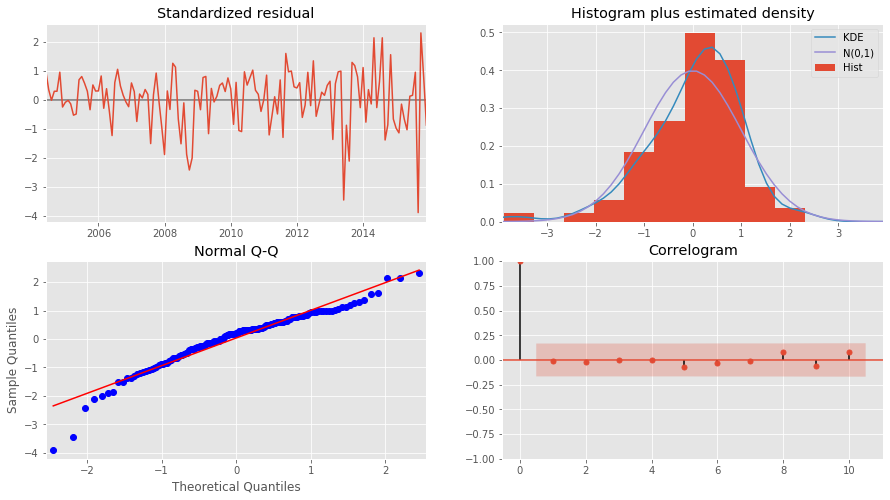

---------------------------------------------------------------
ELS Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -398.903
Date:                            Thu, 06 Feb 2020   AIC                            815.805
Time:                                    09:51:07   BIC                            843.020
Sample:                                02-01-2000   HQIC                           826.861
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -4.753e-05      0.001     -

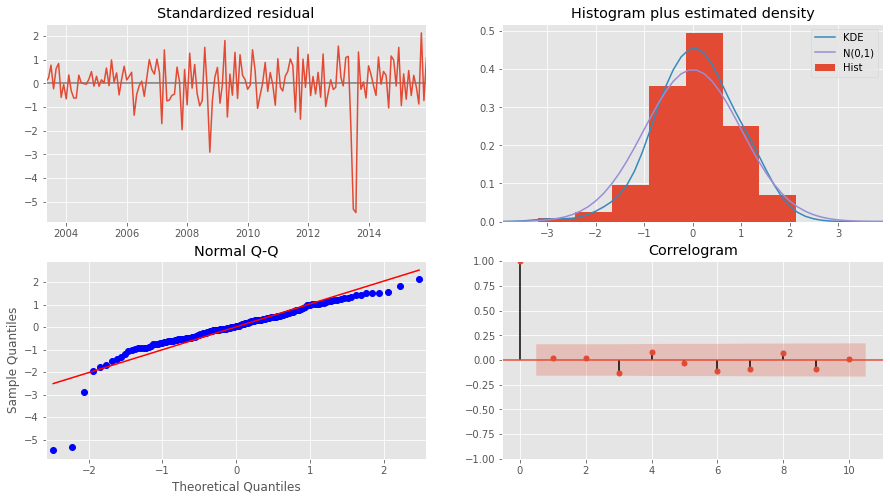

---------------------------------------------------------------
PLD Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -375.267
Date:                            Thu, 06 Feb 2020   AIC                            768.533
Time:                                    09:51:13   BIC                            795.689
Sample:                                02-01-2000   HQIC                           779.565
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0002      0.001     -

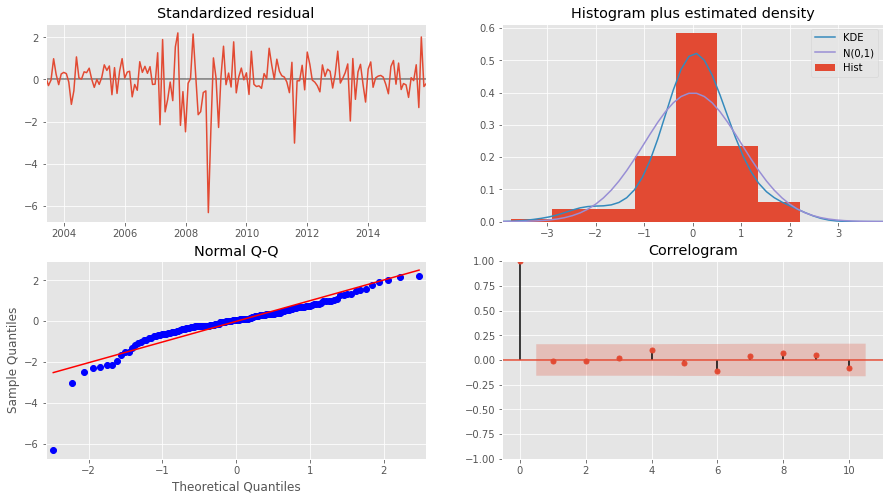

---------------------------------------------------------------
FR Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -274.928
Date:                            Thu, 06 Feb 2020   AIC                            579.856
Time:                                    09:51:32   BIC                            623.765
Sample:                                02-01-2000   HQIC                           597.700
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0

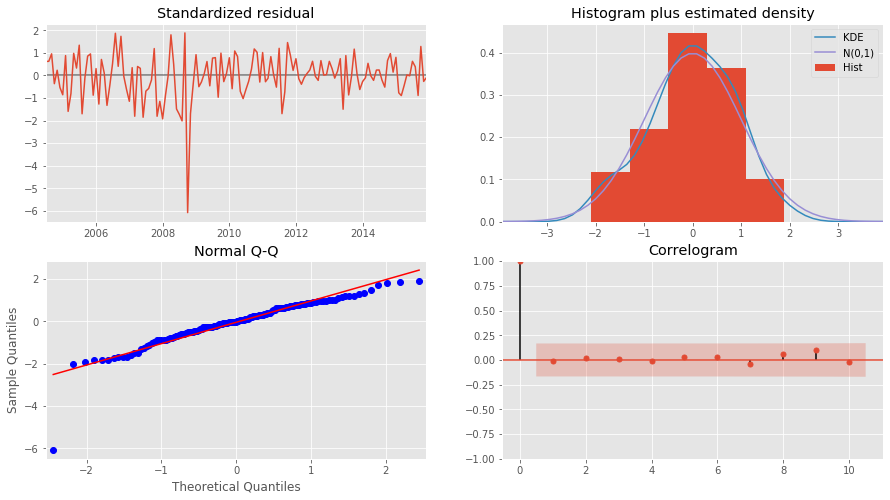

---------------------------------------------------------------
MAA Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -340.605
Date:                            Thu, 06 Feb 2020   AIC                            707.211
Time:                                    09:51:44   BIC                            745.359
Sample:                                02-01-2000   HQIC                           722.713
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0018      0.003      

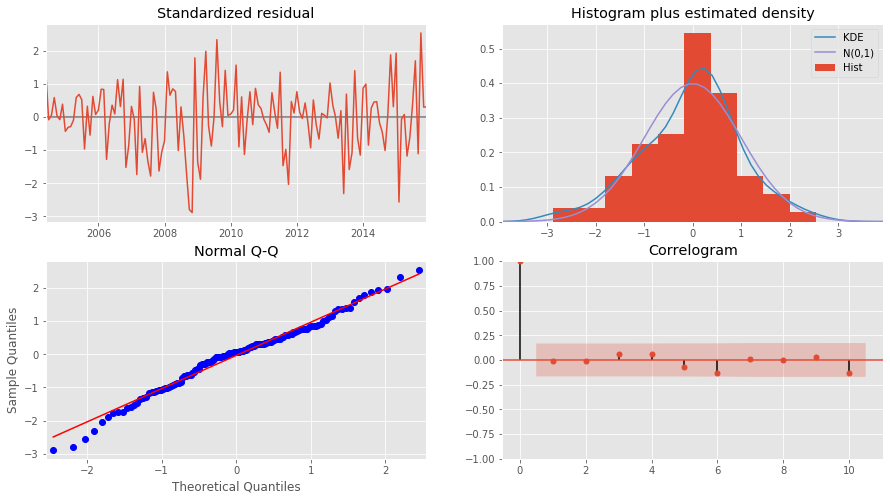

---------------------------------------------------------------
SUI Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -294.531
Date:                            Thu, 06 Feb 2020   AIC                            619.061
Time:                                    09:52:04   BIC                            662.970
Sample:                                02-01-2000   HQIC                           636.905
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0021      0.007      

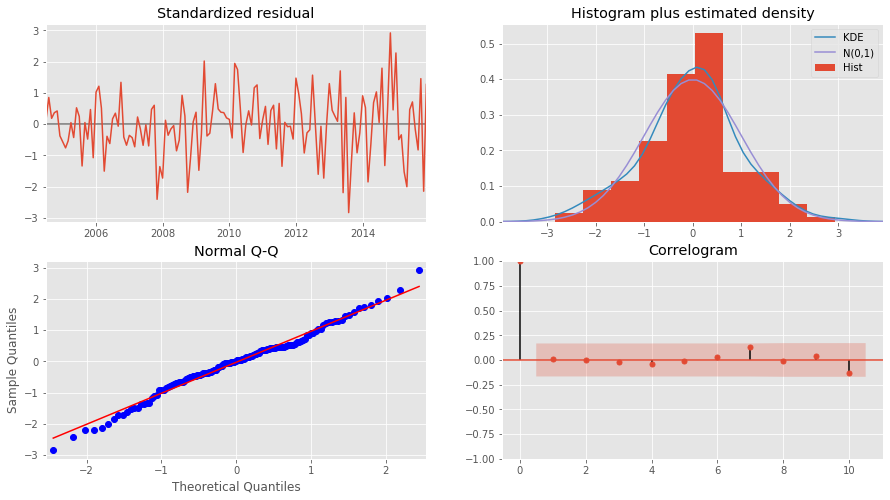

---------------------------------------------------------------
BXMT Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -382.518
Date:                            Thu, 06 Feb 2020   AIC                            779.037
Time:                                    09:52:07   BIC                            800.736
Sample:                                02-01-2000   HQIC                           787.846
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       4.996e-05      0.000     

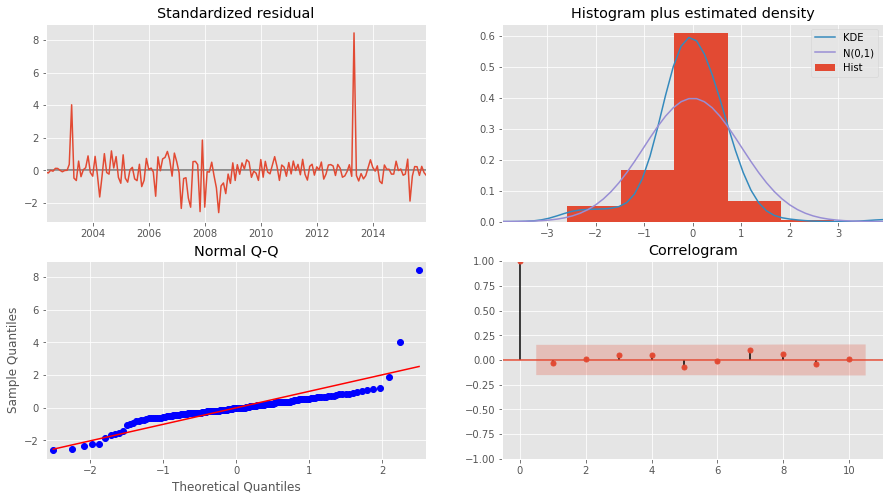

---------------------------------------------------------------
RHP Summary                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -348.463
Date:                            Thu, 06 Feb 2020   AIC                            722.927
Time:                                    09:52:20   BIC                            761.075
Sample:                                02-01-2000   HQIC                           738.429
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0008      0.002      

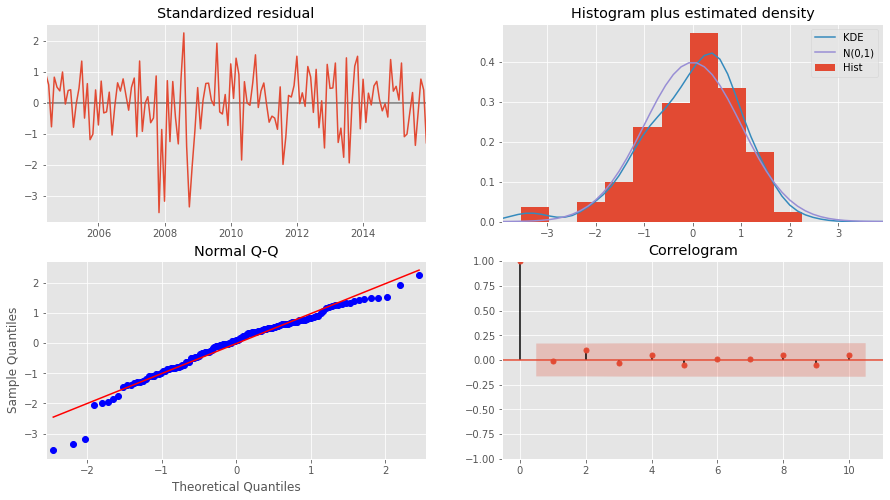

---------------------------------------------------------------


In [115]:
final_results_dict = {}
for key in train_reit_df_dict.keys():
    ts = train_reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, 
                                            exog = libor_train,
                                            order = final_parameters[key],
                                            seasonal_order = final_seasonal_parameters[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    final_results_dict[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

## Final Model Prediction w/ Observed

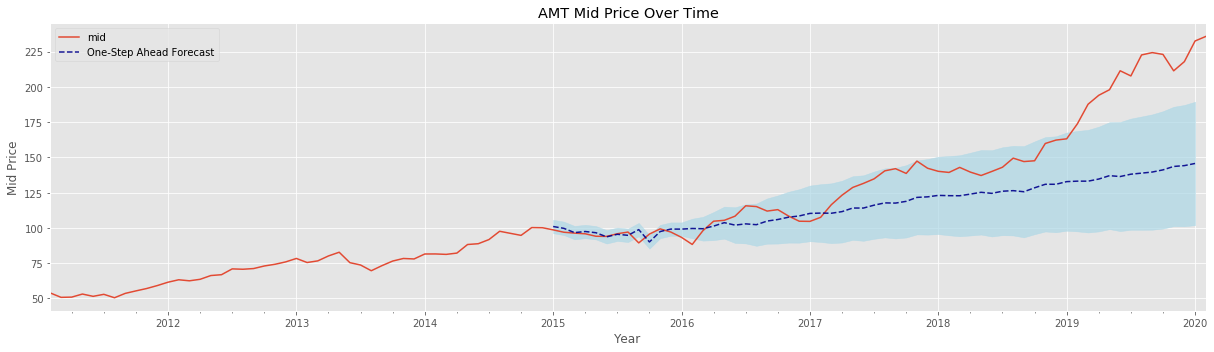

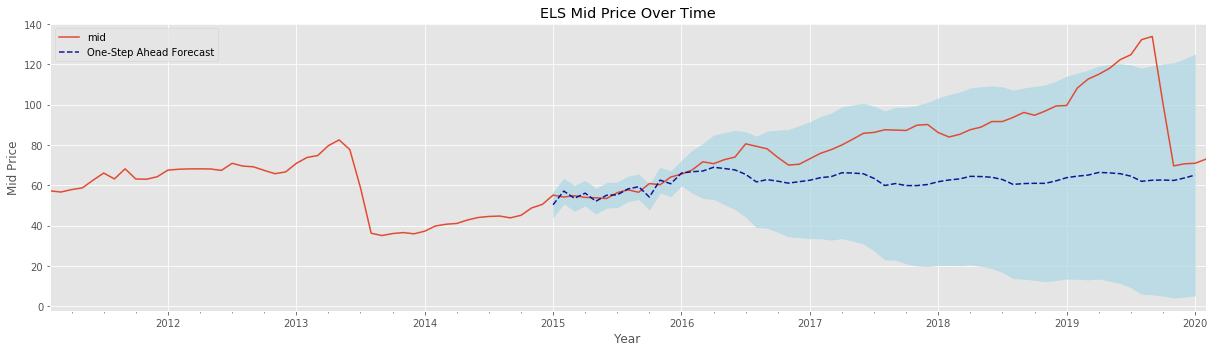

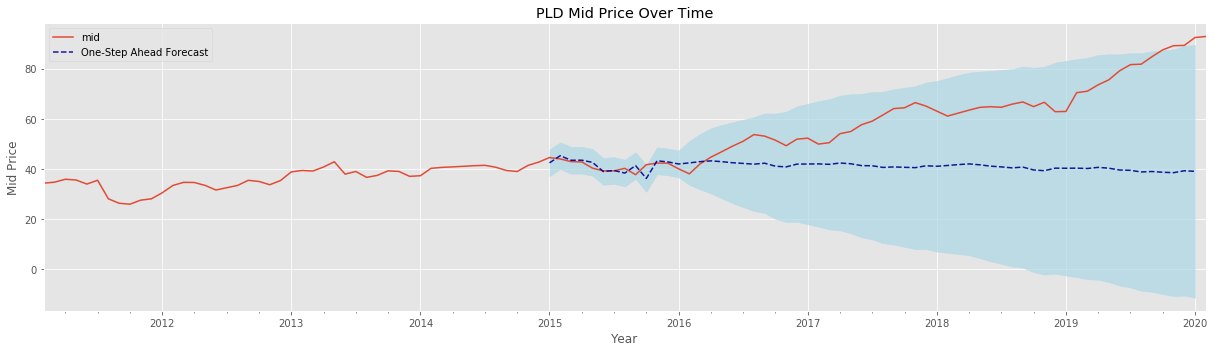

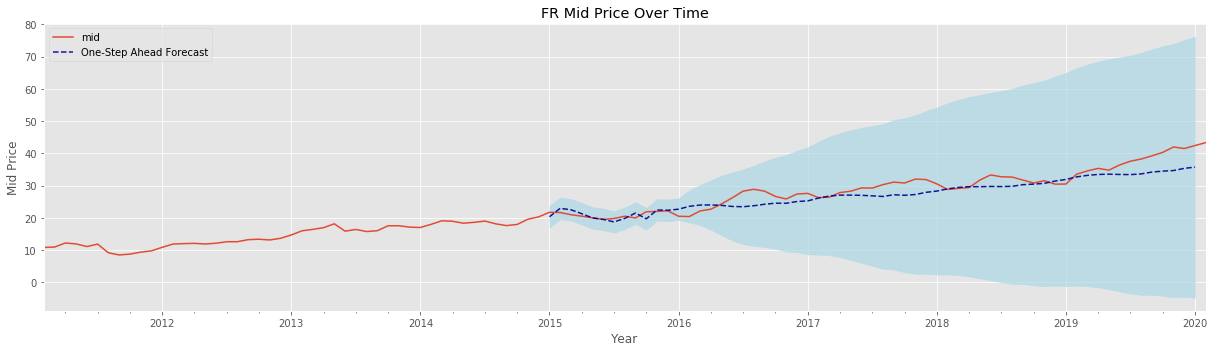

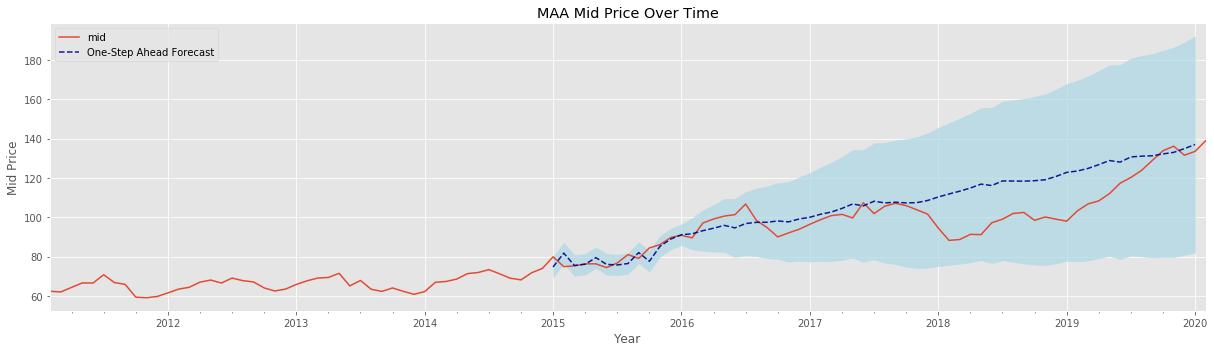

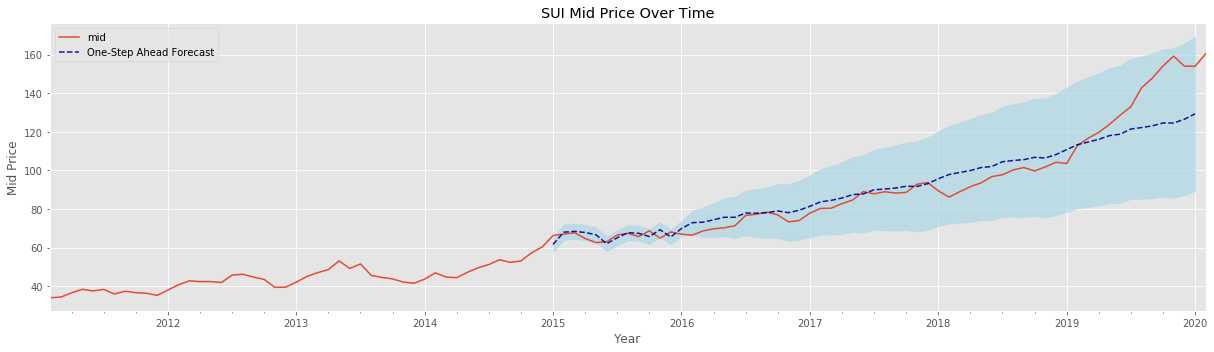

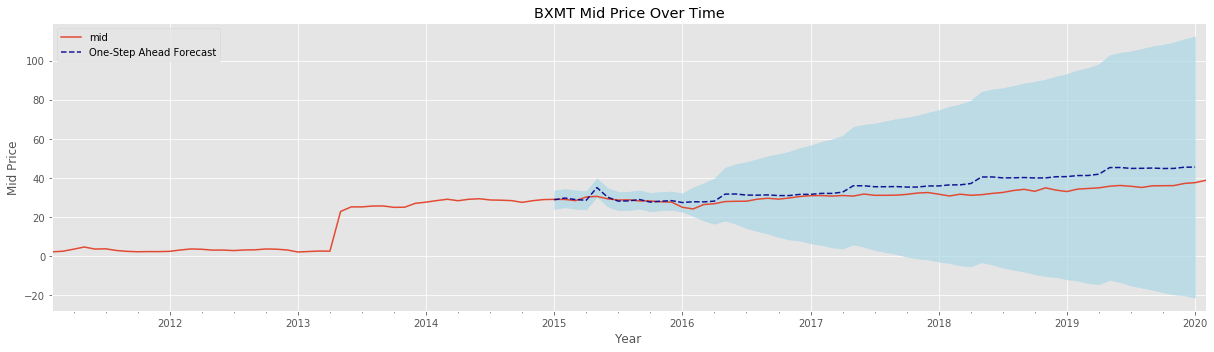

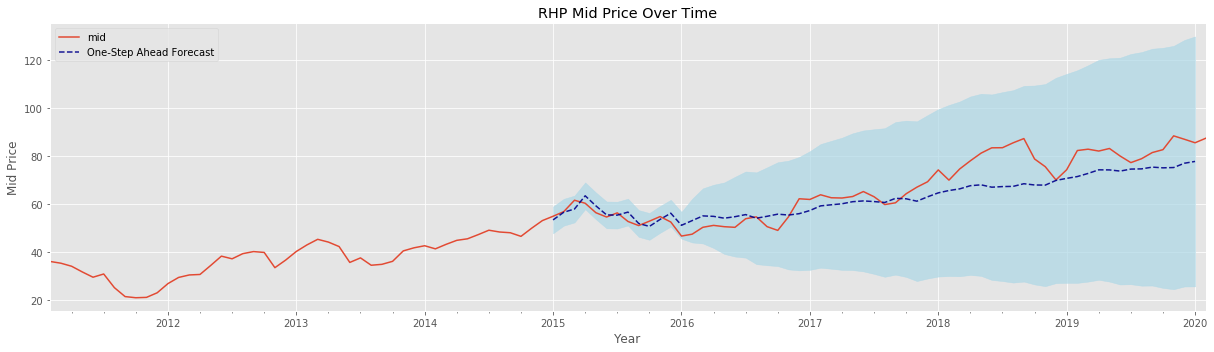

In [166]:
## Get predictions starting from 2000 and display confidence intervals.
# Compare predictions to actual data 2000-2014
for key in final_results_dict.keys():
    results = final_results_dict[key]
    predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), end = pd.to_datetime('2020-01-01'), dynamic=False, exog = libor_test)
    pred_conf = predictions.conf_int()
    
    #Plot observed values
    ax = reit_df_dict[key]['2011-02-01':].plot(label='observed', figsize = (17,5))

    #Plot predicted values
    predictions.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.9, color = 'darkblue', style = '--')

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

    #Set axes labels
    ax.set_xlabel('Year')
    ax.set_ylabel('Mid Price')
    plt.legend(loc = 'upper left')
    plt.title(f'{key} Mid Price Over Time')
    plt.tight_layout()
    plt.show()
    

## Final Model Forecast

In [135]:
final_results_dict

{'AMT': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x14cbd3828>,
 'ELS': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x19a0cb6a0>,
 'PLD': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1488145f8>,
 'FR': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x157340390>,
 'MAA': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x1a9b79eb8>,
 'SUI': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x147e38b00>,
 'BXMT': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x14c4416a0>,
 'RHP': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x14920e780>}

In [170]:
for key in final_results_dict.keys():
    results = final_results_dict[key]
    prediction = results.get_forecast(steps = 36)
    pred_conf = prediction.conf_int()
    
    ax = reit_df_dict[key].plot(label = 'observed', figsize = (17,5))
    prediction.predicted_mean.plot(ax=ax, label = 'Forecast')
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1],
                    color = 'k', alpha = .25)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Mid Price')
    plt.title(f"{key} Mid Price Over Time & Forecast")
    plt.legend(loc = 'upper left')
    plt.show()
    

ValueError: Out-of-sample forecasting in a model with a regression component requires additional exogenous values via the `exog` argument.

## Auto-ARIMA:

In [130]:
for key in train_reit_df_dict.keys():
    print(f"{key}:")
    ts = train_reit_df_dict[key]
    auto_arima = auto_arima = pm.auto_arima(ts, 
                      exogenous = libor_train,
                      error_action='ignore', trace=True,
                      suppress_warnings=True, d =1,
                      seasonal=True, m=12,
                      start_p=0, start_q=0,
                      start_P=0, start_Q=0,
                      stationary=False,
                      with_intercept=False, 
                      D = 12, trend = 't')

AMT:
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 12, 0, 12); AIC=738.147, BIC=743.633, Fit time=74.123 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 12, 0, 12); AIC=1179.261, BIC=1188.405, Fit time=105.150 seconds
Near non-invertible roots for order (1, 1, 0)(1, 12, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 12, 1, 12); AIC=789.927, BIC=799.070, Fit time=185.616 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 12, 0, 12); AIC=1118.052, BIC=1125.367, Fit time=71.400 seconds
Near non-invertible roots for order (0, 1, 0)(1, 12, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 12, 1, 12); AIC=nan, BIC=nan, Fit time=140.688 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 12, 1, 12); AIC=1160.172, BIC=1169.315, Fit time=57.156 seconds
Near non-invertible roots 

KeyboardInterrupt: 